 # **TRABAJO FINAL DEL MASTER: CLUSTERIZACIÓN Y CREACIÓN DE CARTERAS DE INVERSIÓN**

1.   **Santiago Tavera Cardozo**
2.  **NILSON DELGADO**
3. **SERGIO ALEJANDRO ALVARADO**

---
---

#**Etapa 1: Análisis de Datos**


En esta etapa, realizamos un análisis exploratorio de los datos financieros para obtener información clave sobre las variables y su relación. También llevamos a cabo la preparación inicial de los datos antes de entrar en la fase de clustering.

In [78]:
#Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
from ipywidgets import interact, Dropdown, widgets, Checkbox
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D


In [79]:
# Creamos la función que ajusta los meses

def quarter(month):

  if month <= 3:
    return 3
  if month <= 6:
    return 6
  if month <= 9:
    return 9
  if month <= 12:
    return 12

# Ajustamos el dataset final con los KPIs y la llave
df = pd.read_csv("https://raw.githubusercontent.com/nilsondel/TFM/main/df_kpi_modelo.csv")
#df = pd.read_csv("https://media.githubusercontent.com/media/Santigago97/Master/main/df_kpi_modelo_2.csv")
df["Year"] = df["Date"].str[:4]
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Date'] =  df['Date'].apply(lambda x: x.year).astype(str) + '-' + \
    df['Date'].apply(lambda x: x.month).apply(quarter).astype(str)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df["Month"]=df['Date'].apply(lambda x: x.month)
df['Key_2'] = df['Accion'] + \
                     df['Date'].apply(lambda x: x.year).astype(str) + '-' + \
                     df['Date'].apply(lambda x: x.month).apply(quarter).astype(str)
df = df.loc[df["Month"] == 12]

#Quitamos estas dos variables debido a la correlación que manejan

df.head()

,Date,Month,Accion,EV / Free Cashflow,EV / EBITDA,EV / Revenue,Total Liabilities / Total Assets,Long Term Liabilities / Total Assets,ROIC,Total Current Liabilities / Total Liabilities,ROE,PER,Sector,Year,Key_2
1,2022-12-01,12,A,121.312329,83.223340,24.800465,0.496297,0.319597,0.068081,0.356036,0.069369,102.651304,Healthcare,2022,A2022-12
5,2021-12-01,12,A,128.061779,87.999053,29.315347,0.496590,0.337039,0.071680,0.321294,0.082019,94.829294,Healthcare,2021,A2021-12
9,2020-12-01,12,A,105.456221,97.644649,24.888522,0.493819,0.341436,0.052150,0.308582,0.045557,129.933854,Healthcare,2020,A2020-12
13,2019-12-01,12,A,93.973500,81.367299,19.523390,0.497672,0.277613,0.043651,0.442177,0.040859,104.748873,Healthcare,2019,A2019-12
17,2018-12-01,12,A,60.318325,63.922250,15.708868,0.464817,0.327713,0.063608,0.294962,0.042698,85.848245,Healthcare,2018,A2018-12


## Descripción de Variables

Las variables financieras utilizadas fueron:

-  Accion: El nombre de la acción de la empresa.
-  EV / Free Cashflow: Relación entre el valor de la empresa (Enterprise Value) y el flujo de efectivo libre.
-  EV / EBITDA: Relación entre el valor de la empresa (Enterprise Value) y el EBITDA.
-  EV / Revenue: Relación entre el valor de la empresa (Enterprise Value) y los ingresos.
-  Total Liabilities / Total Assets: Relación entre las deudas totales y los activos totales de la empresa.
-  Long Term Liabilities / Total Assets: Relación entre las deudas a largo plazo y los activos totales de la empresa.
-  ROIC (Return on Invested Capital): Indicador de la rentabilidad de los capitales invertidos.
-  Total Current Liabilities / Total Liabilities: Relación entre las deudas a corto plazo y las deudas totales de la empresa.
-  ROE (Return on Equity): Indicador de la rentabilidad sobre el patrimonio neto.
-  PER (Price-Earnings Ratio): Relación entre el precio de la acción y las ganancias por acción.

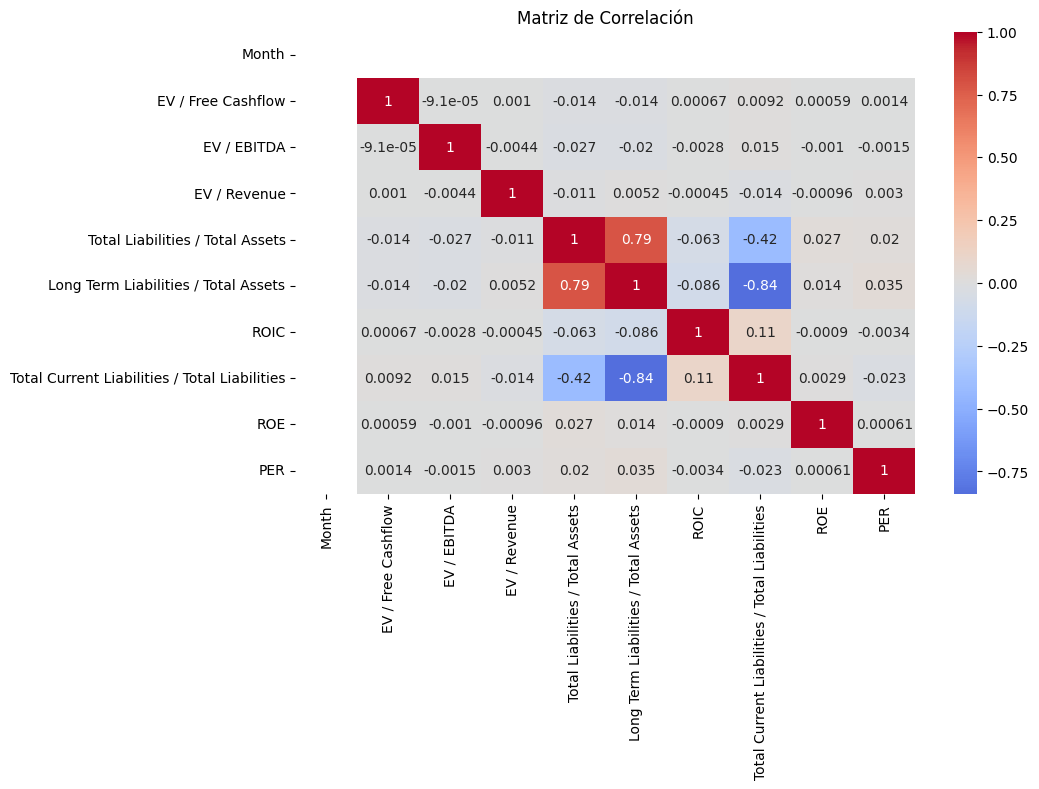

In [80]:
##Mostramos una matriz de correlación para comprender las relaciones entre variables
matriz_correlación = df.corr(numeric_only = True)

plt.figure(figsize=(10, 6))
sns.heatmap(matriz_correlación, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [81]:
# Eliminamos variables redundantes con alta correlación

df.drop(columns=["Total Current Liabilities / Total Liabilities", "Total Liabilities / Total Assets"], inplace = True)

# Etapa 2: Clustering

En esta etapa, aplicamos el algoritmo de clustering K-Means para agrupar las acciones en clusters y analizamos la calidad de los clusters utilizando métricas como el método del codo y la métrica Silhouette.
---

## Clusterización por año

In [82]:
#Vamos a realizar el proceso de clusterización por año

# Obtenemos una lista unica de años
years = df['Year'].unique()
years.sort()

# Creamos un DataFrame para almacenar los resultados
resultado_cluster = pd.DataFrame()

# Iteramos sobre cada año y realizamos el clustering
for year in years:
    data_year = df[df['Year'] == year].drop(['Year',"Date","Key_2", "Month","Sector"], axis=1)
    data_year = data_year.set_index("Accion")
    indices = data_year.index

    # Escalamos los datos
    scaler = MinMaxScaler()
    scaled_data_year = scaler.fit_transform(data_year)

    scaled_data_df = pd.DataFrame(scaled_data_year, columns=data_year.columns, index = indices)

    # Realizamos el clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init = 10)
    cluster_labels = kmeans.fit_predict(scaled_data_df)

    # Agregamos los resultados al DataFrame
    scaled_data_df['Cluster'] = cluster_labels
    scaled_data_df['Year'] = year
    resultado_cluster = pd.concat([resultado_cluster,scaled_data_df])

resultado_cluster.head()

,EV / Free Cashflow,EV / EBITDA,EV / Revenue,Long Term Liabilities / Total Assets,ROIC,ROE,PER,Cluster,Year
Accion,,,,,,,,,
BA,0.501343,0.464829,0.098408,0.463159,0.437906,0.997245,0.897996,1,1993
BDX,0.860124,0.829358,0.384650,0.652972,0.389645,0.996641,1.000000,4,1993
CAH,0.115734,0.710191,0.009997,0.255500,0.472014,0.997614,0.949049,1,1993
COO,0.662309,0.000000,0.206918,1.000000,0.000000,0.000000,0.838042,2,1993
FDX,0.879128,1.000000,0.181656,0.819165,0.421570,0.997233,0.981837,4,1993


## Metodo para encontrar el numero óptimo de clusters

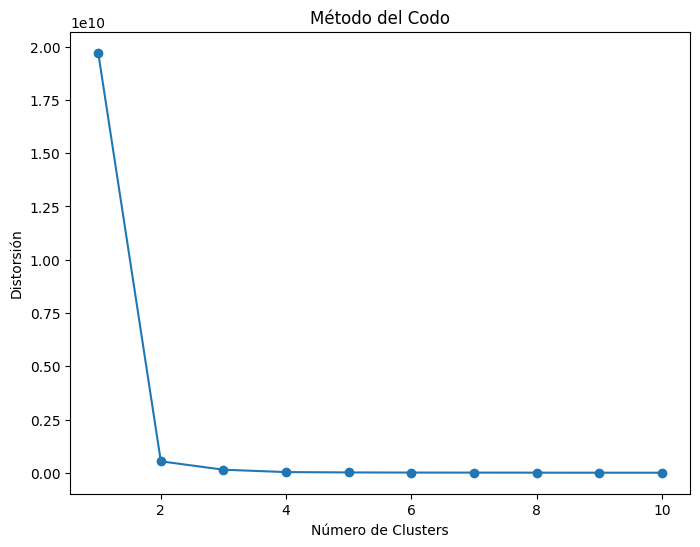

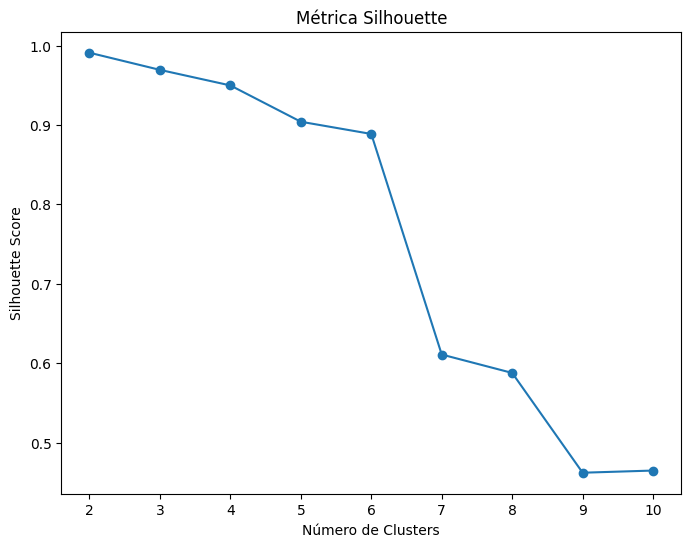

In [83]:
# Metodo del codo para encontrar el numero óptimo de clusters
distortions = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_year)
    distortions.append(kmeans.inertia_)

# Grfico del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), distortions, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Distorsión')
plt.show()

# Metrica silhouette para evaluar la calidad de los clusters
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_year)
    silhouette_avg = silhouette_score(data_year, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Grafico de la metrica silhouette
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Métrica Silhouette')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Elegir el numero óptimo de clusters
num_clusters = 5  # Elegir el número óptimo de clusters

# Aplicar K-Means con el número optimo de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(data_year)

data_year['Cluster'] = cluster_labels


## visualizacin clusters

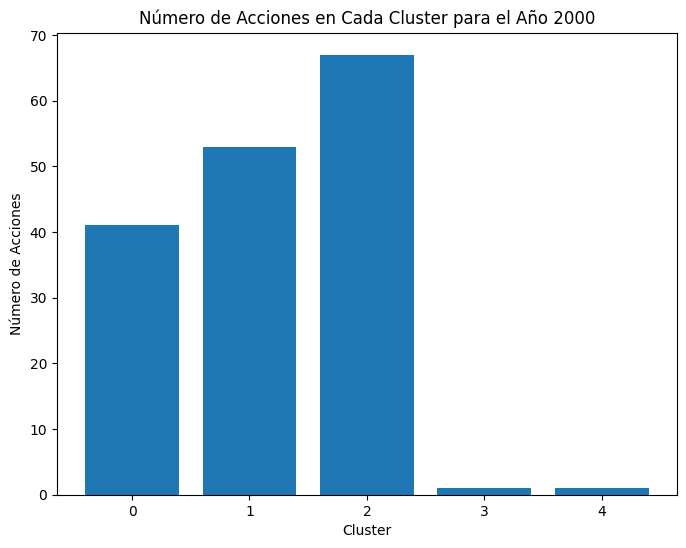

In [84]:
data_yy = resultado_cluster[resultado_cluster['Year'] == '2000']

# Contamos el número de acciones en cada cluster
cluster_counts = data_yy['Cluster'].value_counts().sort_index()

# Graficamos el número de acciones en cada cluster
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Número de Acciones')
plt.title('Número de Acciones en Cada Cluster para el Año 2000')
plt.xticks(cluster_counts.index)
plt.show()


ejemplo de comportamiento de una accion y sus clusters con respecto al año:

<ipython-input-94-5792f5387951>:13: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




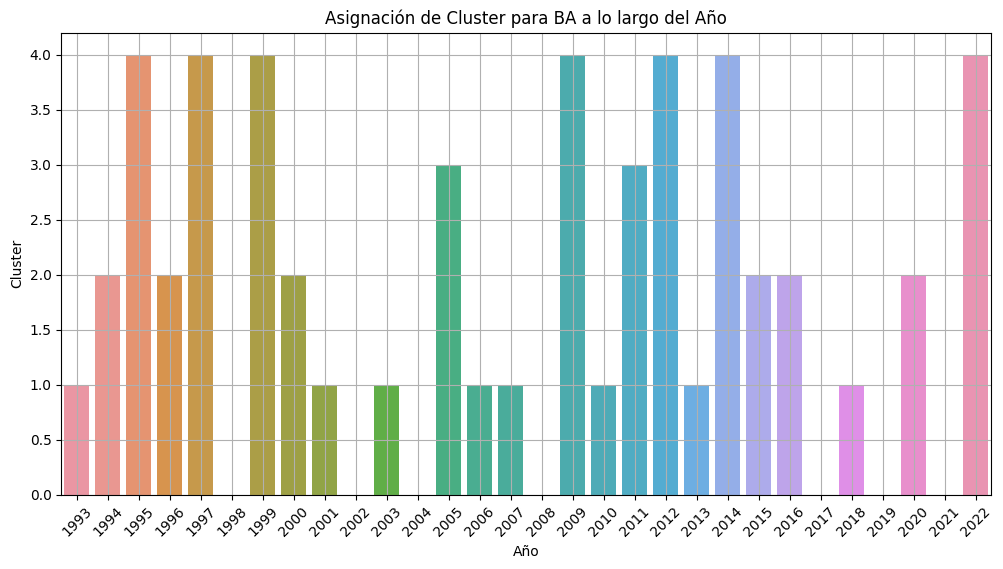

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccion de la variable a analizar
accion_seleccionada = 'BA'

# Filtramos los datos para la acción seleccionada
data_accion_seleccionada = resultado_cluster.loc[resultado_cluster.index == accion_seleccionada]

# Creamos una gráfica de barras apiladas para visualizar los clusters a lo largo del año
plt.figure(figsize=(12, 6))
sns.set_palette("Set1", n_colors=data_accion_seleccionada['Cluster'].nunique())
sns.barplot(x='Year', y='Cluster', data=data_accion_seleccionada, ci=None)
plt.xlabel('Año')
plt.ylabel('Cluster')
plt.title(f'Asignación de Cluster para {accion_seleccionada} a lo largo del Año')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

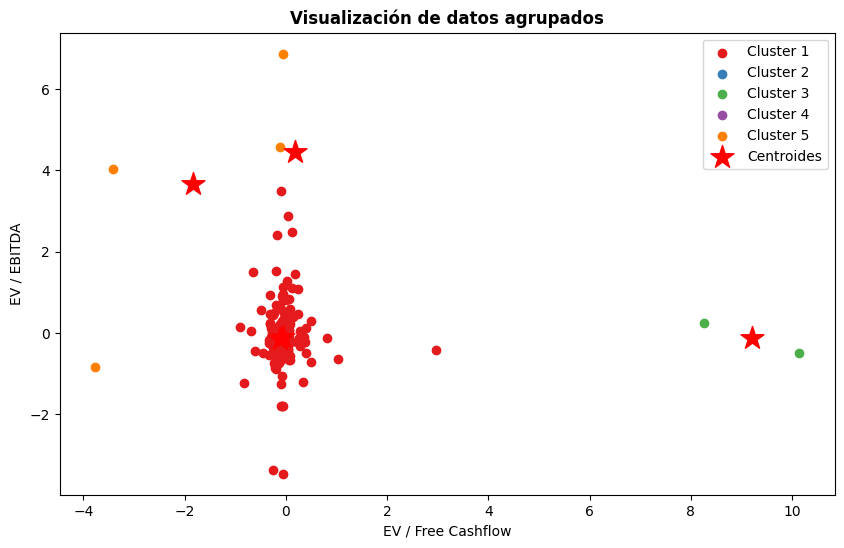

In [98]:
# Standardize the data
X_std = StandardScaler().fit_transform(data_year)

# Run KMeans clustering
num_clusters = 5  # Elegir el número óptimo de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_std)
centroids = kmeans.cluster_centers_

# Plot the clustered data
plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    plt.scatter(X_std[cluster_labels == cluster_num, 0], X_std[cluster_labels == cluster_num, 1],
                label=f'Cluster {cluster_num+1}')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='Centroides')
plt.legend()
plt.xlabel(data_year.columns[0])
plt.ylabel(data_year.columns[1])
plt.title('Visualización de datos agrupados', fontweight='bold')
plt.show()


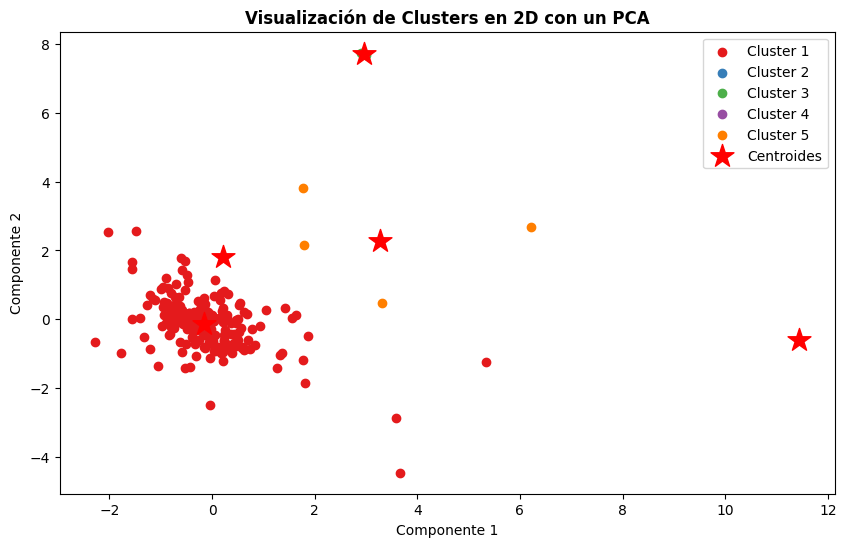

In [99]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(X_std)

# Crear un DataFrame con los datos reducidos y las etiquetas de los clusters
cluster_df = pd.DataFrame(data=data_2d, columns=['Componente 1', 'Componente 2'])
cluster_df['Cluster'] = cluster_labels

# Calcular los centroides en un espacio bidimensional
centroides_2d = pca.transform(centroids)

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    plt.scatter(cluster_df[cluster_df['Cluster'] == cluster_num]['Componente 1'],
                cluster_df[cluster_df['Cluster'] == cluster_num]['Componente 2'],
                label=f'Cluster {cluster_num+1}')
plt.scatter(centroides_2d[:, 0], centroides_2d[:, 1], marker='*', s=300,
            c='r', label='Centroides')
plt.legend()
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Visualización de Clusters en 2D con un PCA', fontweight='bold')
plt.show()


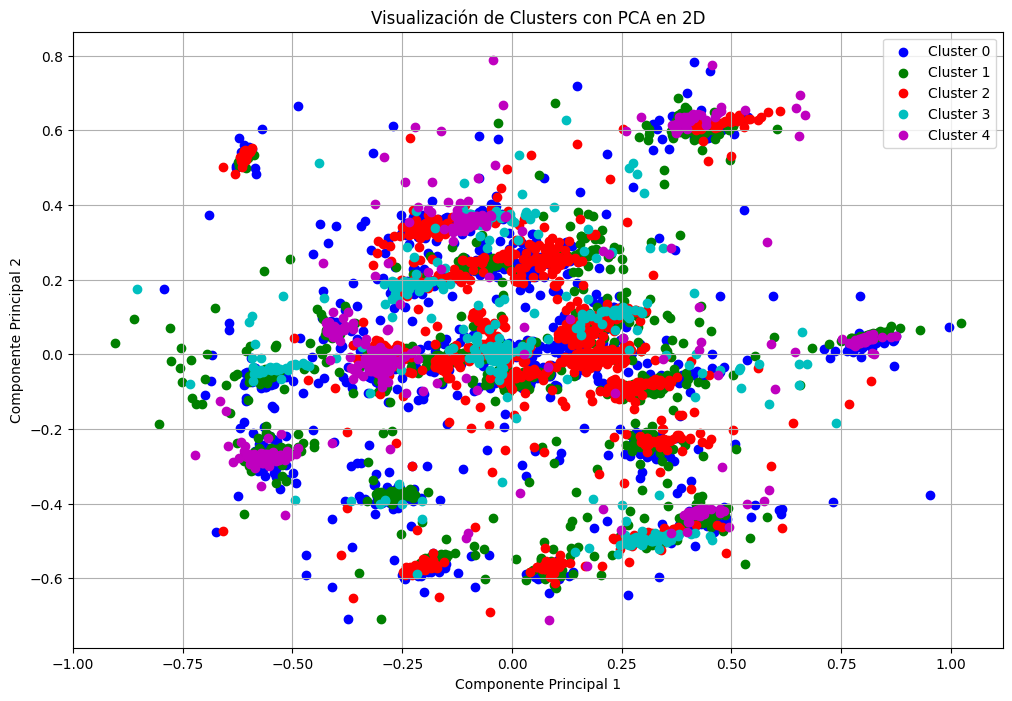

In [100]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Realizar PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)

# Crear un DataFrame sin duplicados en las etiquetas de las acciones
unique_labels = resultado_cluster.index.unique()
unique_data = resultado_cluster.loc[unique_labels].drop(['Cluster', 'Year'], axis=1)
cluster_2d = pca.fit_transform(unique_data)

# Obtener las etiquetas de los clusters correspondientes a las acciones únicas
cluster_labels = resultado_cluster.loc[unique_labels]['Cluster']

# Crear un nuevo DataFrame para la visualización
cluster_2d_df = pd.DataFrame(data=cluster_2d, columns=['Componente 1', 'Componente 2'])
cluster_2d_df['Cluster'] = cluster_labels.values  # Asignar etiquetas de cluster
cluster_2d_df['Year'] = resultado_cluster.loc[unique_labels]['Year'].values  # Asignar años

# Visualizar los clusters en 2D
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm']

for cluster_num in range(5):
    cluster_data = cluster_2d_df[cluster_2d_df['Cluster'] == cluster_num]
    plt.scatter(cluster_data['Componente 1'], cluster_data['Componente 2'], label=f'Cluster {cluster_num}', c=colors[cluster_num])

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización de Clusters con PCA en 2D')
plt.legend()
plt.grid(True)
plt.show()


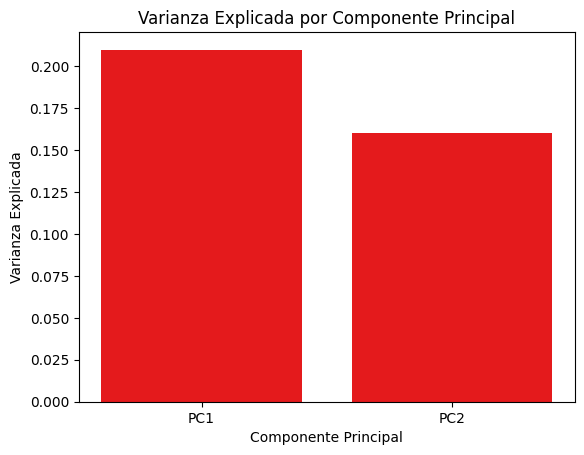

In [101]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supongamos que ya tienes definidas las variables X (matriz de características) y y (etiquetas de clase)

# Crear una instancia de PCA con el número de componentes deseados (por ejemplo, 2)
n_components = 2
pca = PCA(n_components=n_components)

# Ajustar el PCA a tus datos
X_pca = pca.fit_transform(X_std)

# Varianza explicada por cada componente principal
explained_variance = pca.explained_variance_ratio_

# Graficar la varianza explicada
plt.bar(range(n_components), explained_variance, tick_label=[f'PC{i+1}' for i in range(n_components)])
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.show()


## Metricas de kmeans

In [103]:
# Aplicar K-Means con el número optimo de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(data_year)

data_year['Cluster'] = cluster_labels

## Calculo de las metricas de evaluacion

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, normalized_mutual_info_score

inertia = kmeans.inertia_

# Silhouette
silhouette_avg = silhouette_score(data_year, cluster_labels)

# Davies-Bouldin Index
davies_bouldin_index = davies_bouldin_score(data_year, cluster_labels)

# Calinski-Harabasz Index (Variance Ratio Criterion)
calinski_harabasz_index = calinski_harabasz_score(data_year, cluster_labels)

# Homogeneity, Completeness, and V-Measure
homogeneity = homogeneity_score(data_year['Cluster'], cluster_labels)
completeness = completeness_score(data_year['Cluster'], cluster_labels)
v_measure = v_measure_score(data_year['Cluster'], cluster_labels)

# Adjusted Rand Index
adjusted_rand_index = adjusted_rand_score(data_year['Cluster'], cluster_labels)

# Normalized Mutual Information
normalized_mutual_info = normalized_mutual_info_score(data_year['Cluster'], cluster_labels)

# Mostrar las metricas
print(f'Inertia: {inertia}')
print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {davies_bouldin_index}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_index}')
print(f'Homogeneity: {homogeneity}')
print(f'Completeness: {completeness}')
print(f'V-Measure: {v_measure}')
print(f'Adjusted Rand Index: {adjusted_rand_index}')
print(f'Normalized Mutual Information: {normalized_mutual_info}')




Inertia: 17744323.754329126
Silhouette Score: 0.9041200843967088
Davies-Bouldin Index: 0.09904504006441357
Calinski-Harabasz Index: 58542.718766037775
Homogeneity: 1.0
Completeness: 1.0
V-Measure: 1.0
Adjusted Rand Index: 1.0
Normalized Mutual Information: 1.0


## Comparacion cluster con SOM

In [104]:
pip install MiniSom


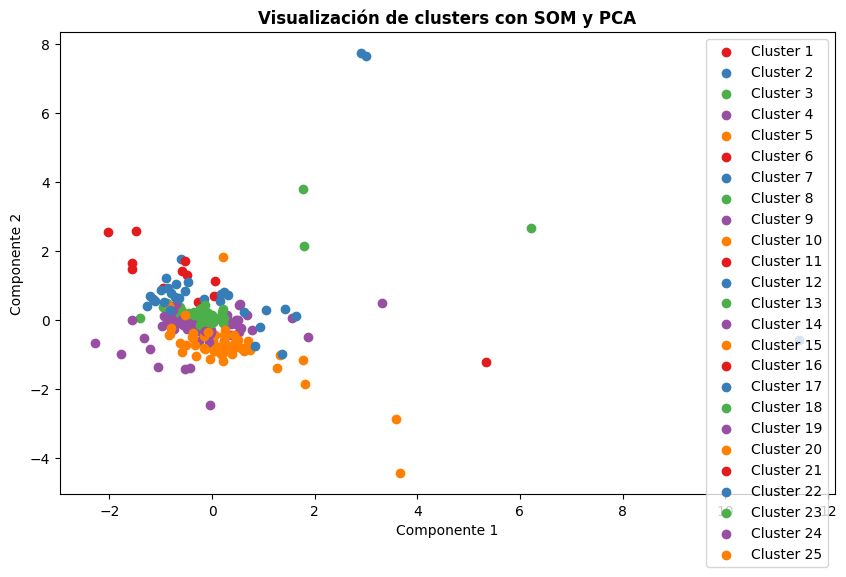

In [105]:
from minisom import MiniSom
import matplotlib.pyplot as plt
import numpy as np

# Datos de entrada
data_input = X_std  # Usamos los datos estandarizados

# Definir el tamaño de la cuadrícula SOM
grid_size = (5, 5)

# Crear una instancia de MiniSom
som = MiniSom(grid_size[0], grid_size[1], data_input.shape[1], sigma=1.0, learning_rate=0.5)

# Inicializar los pesos de forma aleatoria
som.random_weights_init(data_input)

# Entrenar el SOM
num_epochs = 1000  # Numero de épocas de entrenamiento
som.train_random(data_input, num_epochs)

# Asignar cada punto de datos a un cluster en el SOM
cluster_labels = np.zeros(data_input.shape[0], dtype=int)
for i, x in enumerate(data_input):
    winner = som.winner(x)
    cluster_labels[i] = winner[0] * grid_size[1] + winner[1]

# Visualizar los clusters en 2D con PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_input)

plt.figure(figsize=(10, 6))
for cluster_num in range(grid_size[0] * grid_size[1]):
    plt.scatter(data_2d[cluster_labels == cluster_num, 0],
                data_2d[cluster_labels == cluster_num, 1],
                label=f'Cluster {cluster_num+1}')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Visualización de clusters con SOM y PCA', fontweight='bold')
plt.legend()
plt.show()

metricas de comparacion con kmeans

In [106]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Calcular la puntuación de silueta para SOM
silhouette_som = silhouette_score(data_input, cluster_labels)  # Utiliza los cluster_labels de SOM

# Calcular la puntuación Calinski-Harabasz para SOM
calinski_harabasz_som = calinski_harabasz_score(data_input, cluster_labels)  # Utiliza los cluster_labels de SOM

# Imprimir las métricas de SOM
print(f'Silhouette Score (SOM): {silhouette_som}')
print(f'Calinski-Harabasz Score (SOM): {calinski_harabasz_som}')


Silhouette Score (SOM): 0.1405633646508119
Calinski-Harabasz Score (SOM): 50.948651694754616


Comparacion de las metricas de K-Means y SOM:

Para K-Means:

- Silhouette Score: 0.9041200843967088
- Calinski-Harabasz Score: 58542.718766037775

Para SOM:

- Silhouette Score (SOM): 0.18055106158469914
- Calinski-Harabasz Score (SOM): 55.905515255303484


Observaciones basadas en estas metricas:

1. Silhouette Score:

K-Means tiene un Silhouette Score mucho más alto (0.9041) en comparacion con SOM (0.1806).


Un Silhouette Score más alto indica una mejor separacion entre los clusters y una mayor cohesión dentro de cada cluster. En este aspecto, K-Means tiene un rendimiento mejor que SOM en este caso.

2. Calinski-Harabasz Score:

K-Means tiene un Calinski-Harabasz Score mucho más alto (58542.72) en comparación con SOM (55.91).

Un Calinski-Harabasz Score más alto sugiere que los clusters generados por el algoritmo tienen una mayor varianza entre clusters y una menor varianza dentro de cada cluster. En este caso, Kmenas esta generando los clusters de mejor calidad con respecto al SOM.

En resumen, Kmenas tiene un mejor comportamiento que SOM para estos datos.

In [107]:
from minisom import MiniSom
import numpy as np

# Datos de entrada
data_input = X_std  # Usamos los datos estandarizados

# Definir el tamaño de la cuadrícula SOM
grid_size = (5, 5)

# Crear una instancia de MiniSom
som = MiniSom(grid_size[0], grid_size[1], data_input.shape[1], sigma=1.0, learning_rate=0.5)

# Inicializar los pesos de forma aleatoria
som.random_weights_init(data_input)

# Entrenar el SOM
num_epochs = 1000  # Número de épocas de entrenamiento
som.train_random(data_input, num_epochs)

# Asignar cada punto de datos a un cluster en el SOM
cluster_labels = np.zeros(data_input.shape[0], dtype=int)
for i, x in enumerate(data_input):
    winner = som.winner(x)
    cluster_labels[i] = winner[0] * grid_size[1] + winner[1]

# Calcular los centroides de los clusters SOM
cluster_centroids = np.array([np.mean(data_input[cluster_labels == i], axis=0) for i in range(grid_size[0] * grid_size[1])])

# Calcular la distancia entre los centroides
distances = np.zeros((grid_size[0] * grid_size[1], grid_size[0] * grid_size[1]))
for i in range(grid_size[0] * grid_size[1]):
    for j in range(grid_size[0] * grid_size[1]):
        distances[i, j] = np.linalg.norm(cluster_centroids[i] - cluster_centroids[j])

# Definir un umbral para la distancia entre los centroides - ojo!
umbral_distancia = 0.4

# Inicializar la matriz de agregación
aggregated_labels = np.zeros(data_input.shape[0], dtype=int)

# Realizar la agregación de clusters
for i in range(data_input.shape[0]):
    aggregated_labels[i] = np.argmin(distances[cluster_labels[i]])

# Visualizar los clusters agregados
for cluster_num in range(grid_size[0] * grid_size[1]):
    print(f'Cluster Agregado {cluster_num+1}: {np.sum(aggregated_labels == cluster_num)} elementos')



Cluster Agregado 1: 1 elementos
Cluster Agregado 2: 4 elementos
Cluster Agregado 3: 7 elementos
Cluster Agregado 4: 4 elementos
Cluster Agregado 5: 1 elementos
Cluster Agregado 6: 3 elementos
Cluster Agregado 7: 8 elementos
Cluster Agregado 8: 6 elementos
Cluster Agregado 9: 8 elementos
Cluster Agregado 10: 2 elementos
Cluster Agregado 11: 5 elementos
Cluster Agregado 12: 10 elementos
Cluster Agregado 13: 15 elementos
Cluster Agregado 14: 7 elementos
Cluster Agregado 15: 1 elementos
Cluster Agregado 16: 25 elementos
Cluster Agregado 17: 26 elementos
Cluster Agregado 18: 24 elementos
Cluster Agregado 19: 16 elementos
Cluster Agregado 20: 2 elementos
Cluster Agregado 21: 3 elementos
Cluster Agregado 22: 11 elementos
Cluster Agregado 23: 10 elementos
Cluster Agregado 24: 10 elementos
Cluster Agregado 25: 7 elementos


evitando espacio vacio:

In [108]:
from minisom import MiniSom
import numpy as np

# Datos de entrada
data_input = X_std  # Usamos los datos estandarizados

# Definir el tamaño de la cuadrícula SOM
grid_size = (5, 5)

# Crear una instancia de MiniSom
som = MiniSom(grid_size[0], grid_size[1], data_input.shape[1], sigma=1.0, learning_rate=0.5)

# Inicializar los pesos de forma aleatoria
som.random_weights_init(data_input)

# Entrenar el SOM
num_epochs = 1000  # Número de épocas de entrenamiento
som.train_random(data_input, num_epochs)

# Asignar cada punto de datos a un cluster en el SOM
cluster_labels = np.zeros(data_input.shape[0], dtype=int)
for i, x in enumerate(data_input):
    winner = som.winner(x)
    cluster_labels[i] = winner[0] * grid_size[1] + winner[1]

# Inicializar la matriz de agregación
aggregated_labels = np.zeros(data_input.shape[0], dtype=int)

# Realizar la agregación de clusters
for i in range(data_input.shape[0]):
    cluster_num = cluster_labels[i]
    if np.sum(cluster_labels == cluster_num) > 0:
        aggregated_labels[i] = np.argmin(distances[cluster_labels[i]])

# Visualizar los clusters agregados
for cluster_num in range(grid_size[0] * grid_size[1]):
    print(f'Cluster Agregado {cluster_num+1}: {np.sum(aggregated_labels == cluster_num)} elementos')


Cluster Agregado 1: 5 elementos
Cluster Agregado 2: 7 elementos
Cluster Agregado 3: 1 elementos
Cluster Agregado 4: 0 elementos
Cluster Agregado 5: 3 elementos
Cluster Agregado 6: 23 elementos
Cluster Agregado 7: 21 elementos
Cluster Agregado 8: 17 elementos
Cluster Agregado 9: 6 elementos
Cluster Agregado 10: 0 elementos
Cluster Agregado 11: 11 elementos
Cluster Agregado 12: 7 elementos
Cluster Agregado 13: 29 elementos
Cluster Agregado 14: 7 elementos
Cluster Agregado 15: 3 elementos
Cluster Agregado 16: 1 elementos
Cluster Agregado 17: 10 elementos
Cluster Agregado 18: 21 elementos
Cluster Agregado 19: 12 elementos
Cluster Agregado 20: 1 elementos
Cluster Agregado 21: 4 elementos
Cluster Agregado 22: 13 elementos
Cluster Agregado 23: 10 elementos
Cluster Agregado 24: 2 elementos
Cluster Agregado 25: 2 elementos


## Renombrar Clusters con la media del PER

In [109]:
# Renombramos Clusters con la media del PER

# Agrupar por año y cluster, y calcular la media de la columna PER
cluster_means = resultado_cluster.groupby(['Year', 'Cluster'])['PER'].mean().reset_index()

# Para cada año, ordenar los clusters por su media PER y asignar nuevos nombres
cluster_rename_map = {}
for year in cluster_means['Year'].unique():
    year_data = cluster_means[cluster_means['Year'] == year]
    sorted_clusters = year_data.sort_values('PER',ascending = False)['Cluster'].tolist()
    for new_cluster, old_cluster in enumerate(sorted_clusters, start=1):
        cluster_rename_map[(year, old_cluster)] = new_cluster

# Crear la columna "cluster_renombrado" usando el mapa de renombrado
resultado_cluster['cluster_renombrado'] = resultado_cluster.apply(lambda row: cluster_rename_map.get((row['Year'], row['Cluster']), None), axis=1)

resultado_cluster.sort_index()
resultado_cluster["Llave"] = resultado_cluster["Year"].str[:4] + resultado_cluster.index
resultado_cluster.drop(columns = "Cluster", inplace = True)

# Imprimir el DataFrame resultante
resultado_cluster

,EV / Free Cashflow,EV / EBITDA,EV / Revenue,Long Term Liabilities / Total Assets,ROIC,ROE,PER,Year,cluster_renombrado,Llave
Accion,,,,,,,,,,
BA,0.501343,0.464829,0.098408,0.463159,0.437906,0.997245,0.897996,1993,3,1993BA
BDX,0.860124,0.829358,0.384650,0.652972,0.389645,0.996641,1.000000,1993,1,1993BDX
CAH,0.115734,0.710191,0.009997,0.255500,0.472014,0.997614,0.949049,1993,3,1993CAH
COO,0.662309,0.000000,0.206918,1.000000,0.000000,0.000000,0.838042,1993,4,1993COO
FDX,0.879128,1.000000,0.181656,0.819165,0.421570,0.997233,0.981837,1993,1,1993FDX
...,...,...,...,...,...,...,...,...,...,...
WY,0.224717,0.481379,0.099655,0.177854,0.410457,0.346713,0.125981,2022,4,2022WY
XEL,0.249138,0.315408,0.112944,0.426296,0.422551,0.349506,0.125390,2022,3,2022XEL
XYL,0.265667,0.352610,0.098441,0.234742,0.457236,0.352069,0.125629,2022,4,2022XYL


## Funcion de impacto por calculos de promedios (mean) y medianas (median)

<ipython-input-110-24c73180cac0>:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-110-24c73180cac0>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



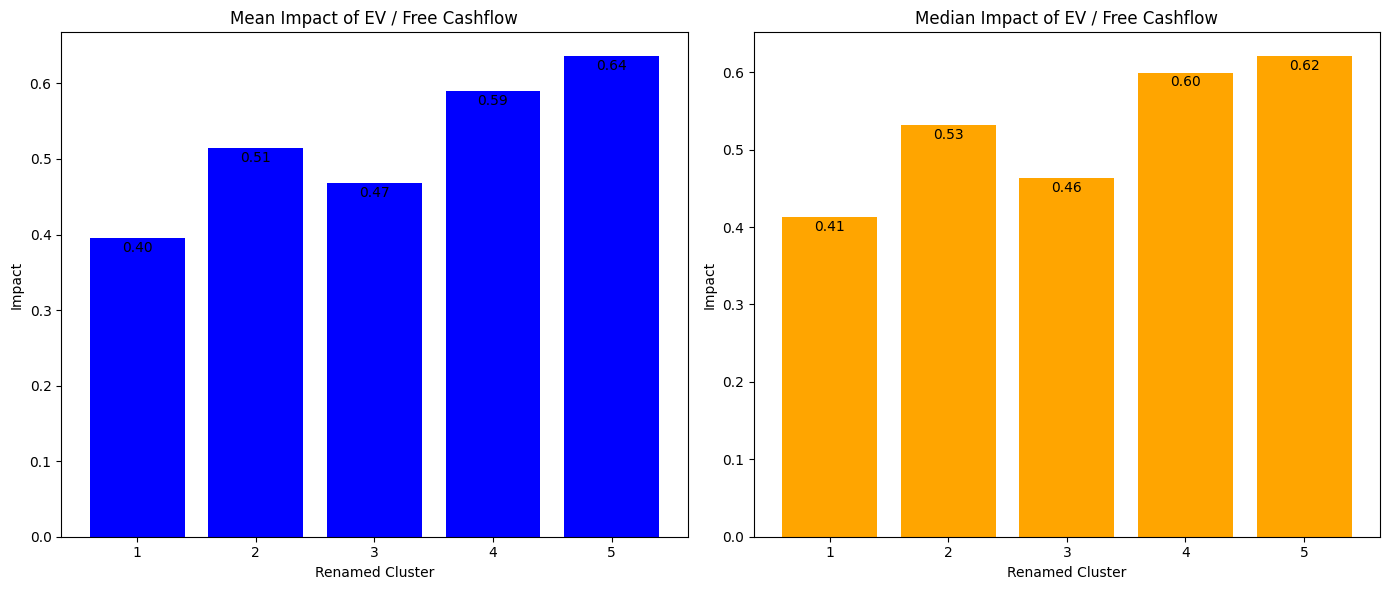

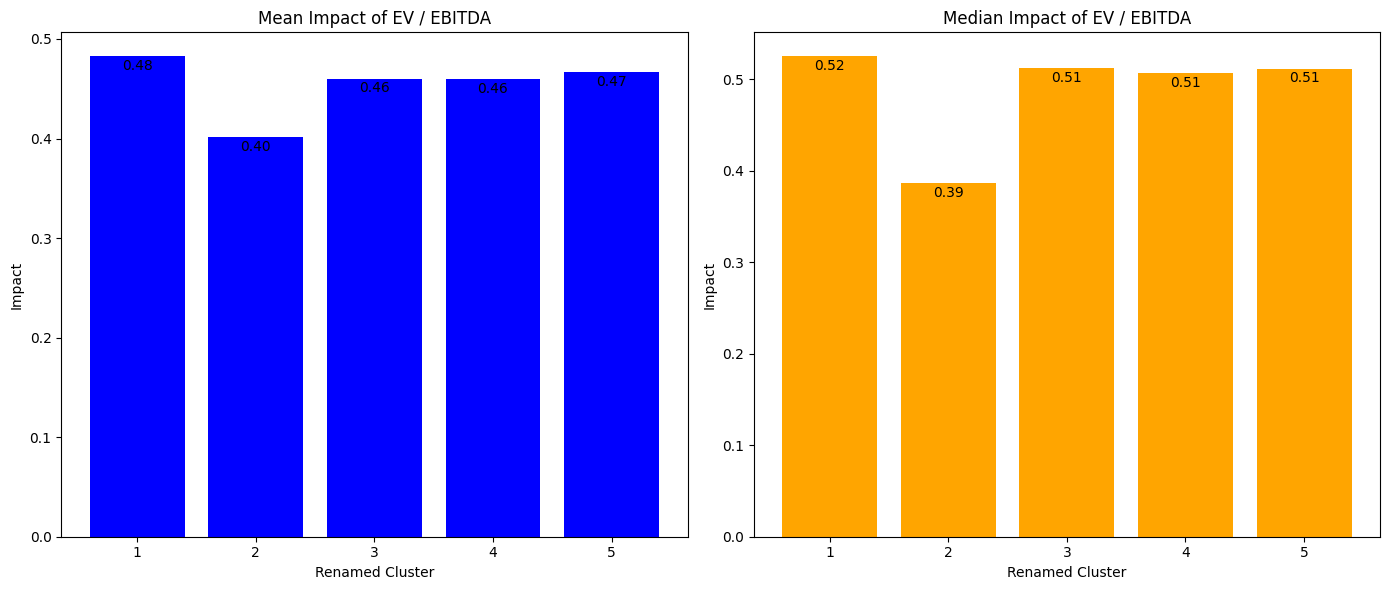

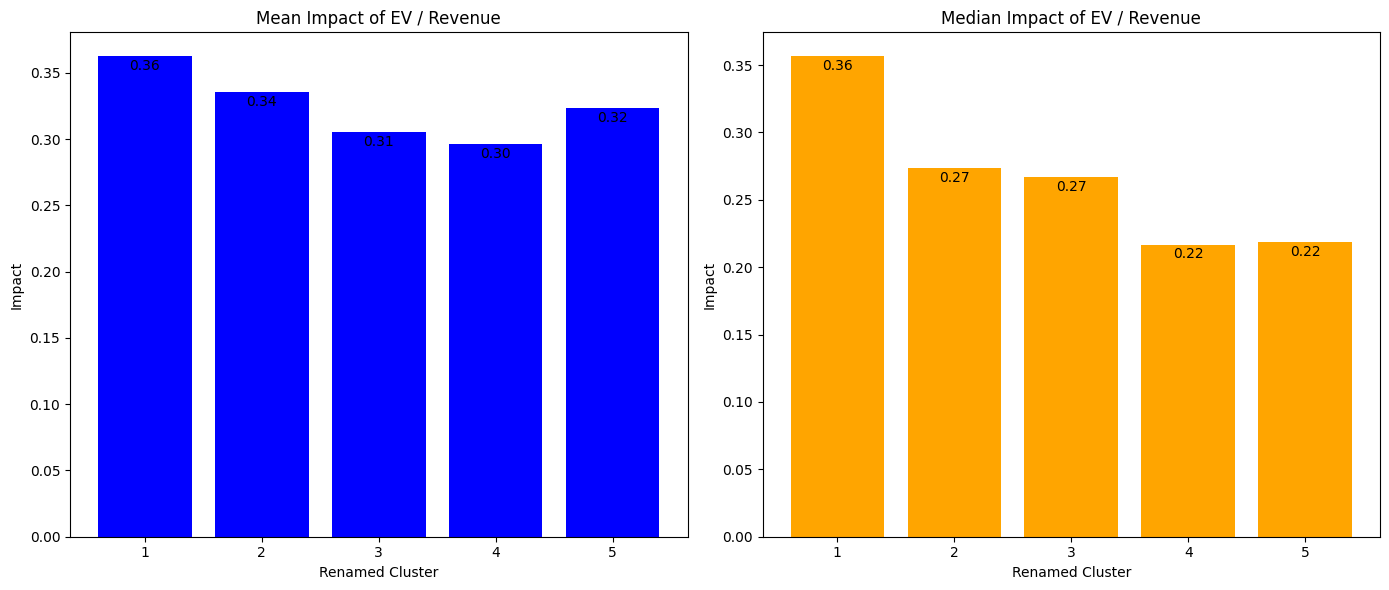

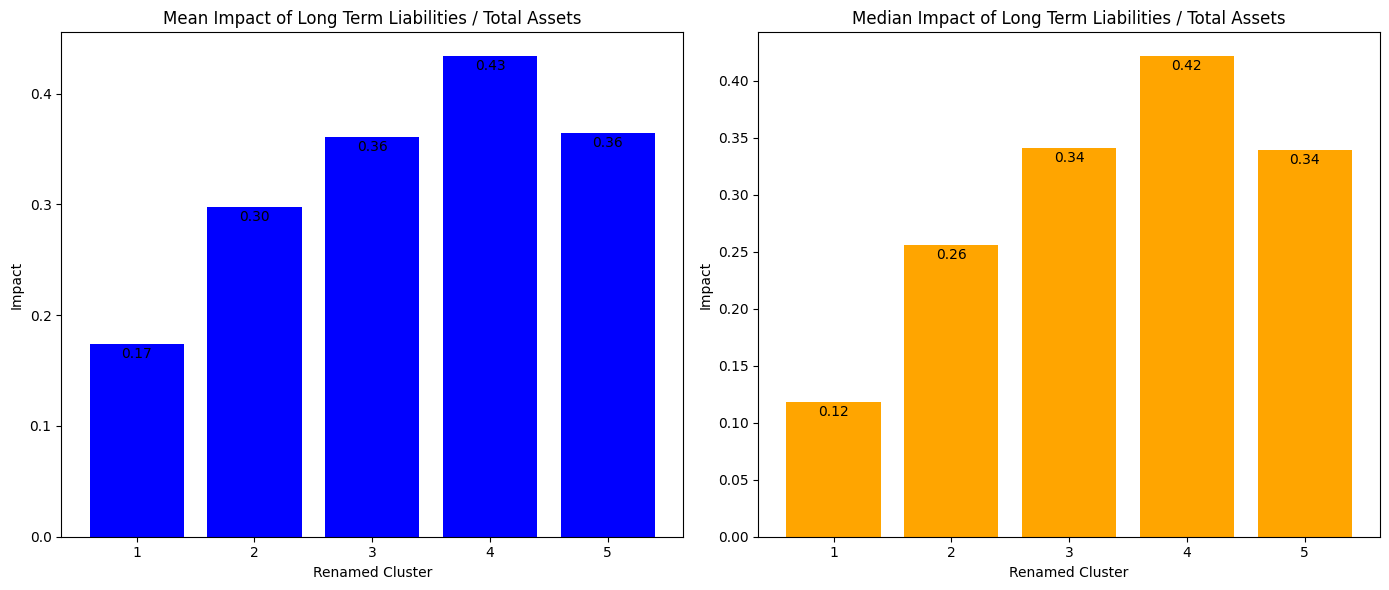

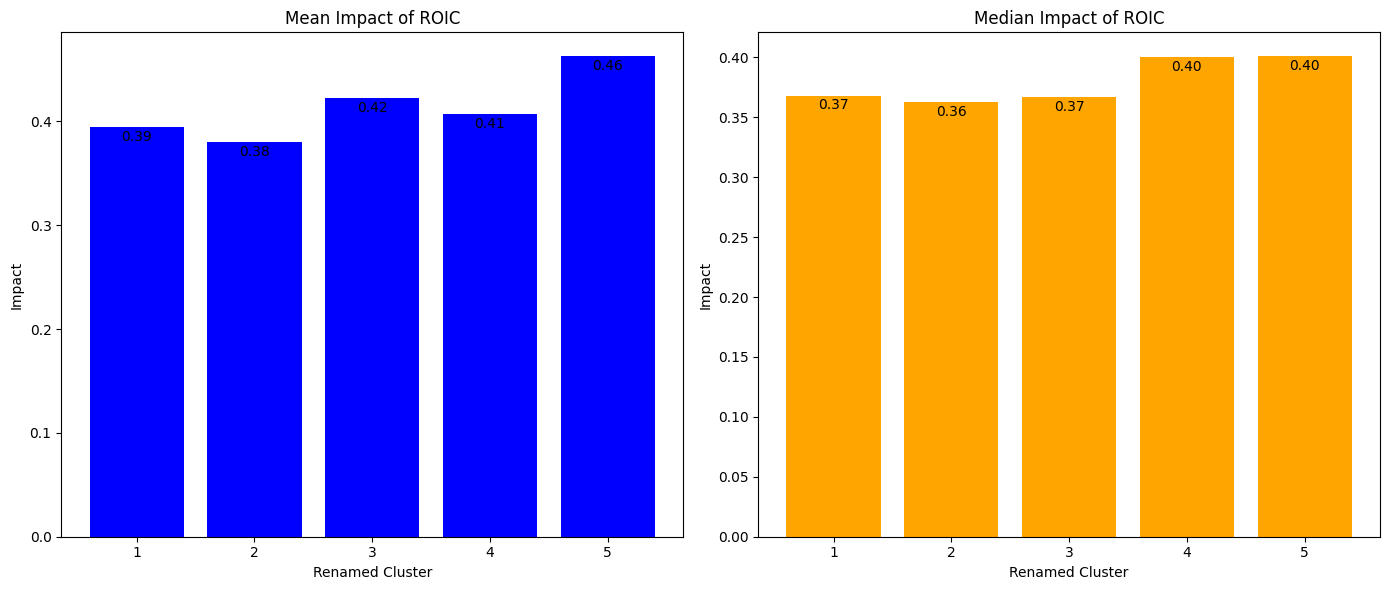

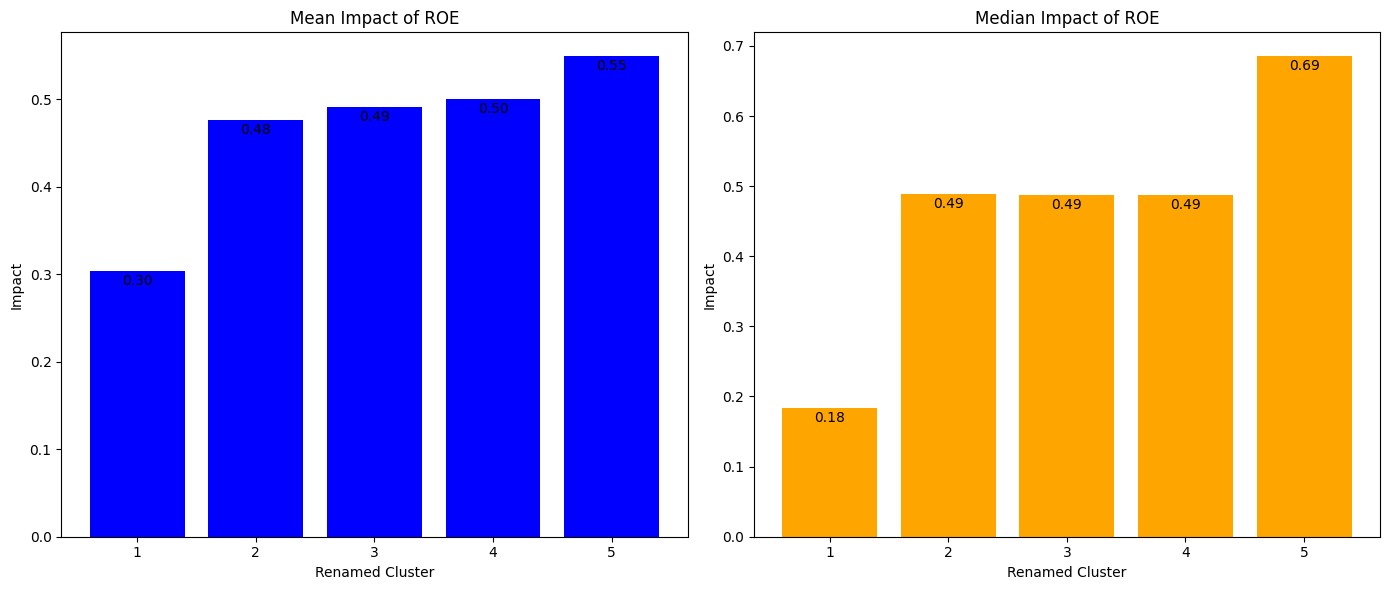

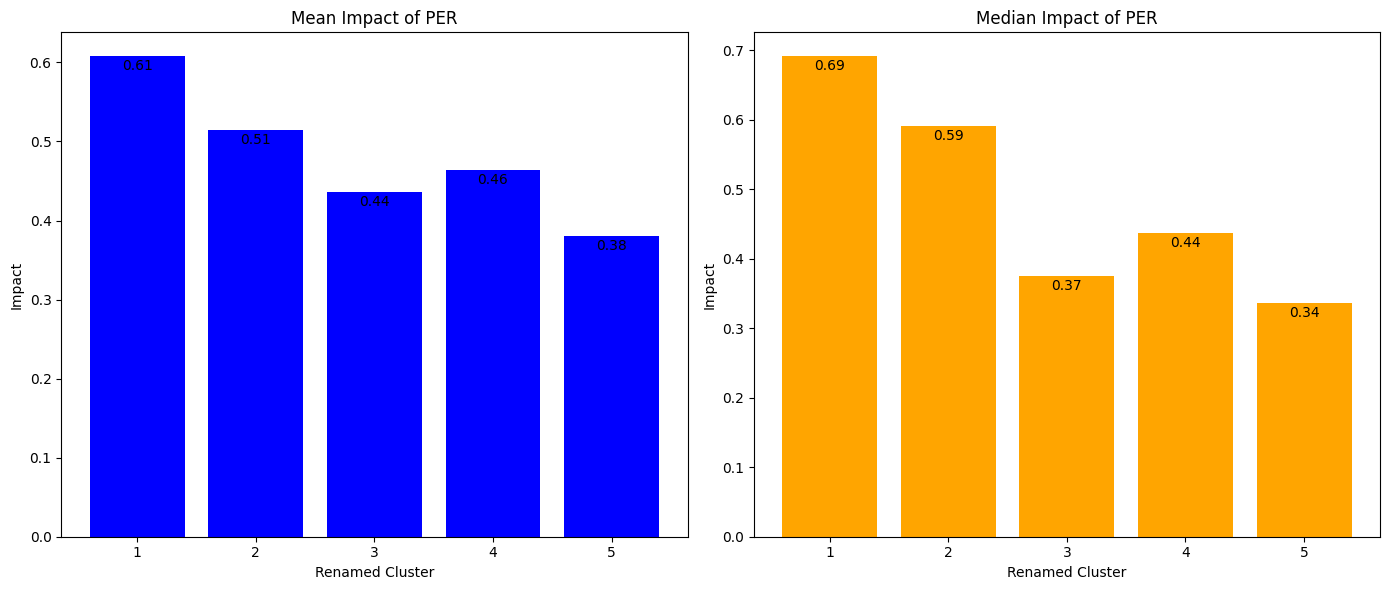

In [110]:

# Funcion de impacto por calculos de promedios (mean) y medianas (median)
def calculate_means_medians(df_clustered):
    center_mean = df_clustered.groupby('cluster_renombrado').mean()
    center_median = df_clustered.groupby('cluster_renombrado').median()
    return center_mean, center_median

# Funcion para crear graficas interactivas comparando los promedios y medianas
def create_interactive_plots(center_mean, center_median):
    for col in center_mean.columns:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        ax1.bar(center_mean.index, center_mean[col], color='blue', label='Mean')
        ax1.set_title(f'Mean Impact of {col}')
        ax1.set_xlabel('Renamed Cluster')
        ax1.set_ylabel('Impact')

        for x, y in zip(center_mean.index, center_mean[col]):
            ax1.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center')


        ax2.bar(center_median.index, center_median[col], color='orange', label='Median')
        ax2.set_title(f'Median Impact of {col}')
        ax2.set_xlabel('Renamed Cluster')
        ax2.set_ylabel('Impact')

        for x, y in zip(center_median.index, center_median[col]):
          ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,-10), ha='center')


        plt.tight_layout()
        plt.show()

# Calcular los promedios y medianas para el resultado_cluster con clusters renombrados
center_mean, center_median = calculate_means_medians(resultado_cluster)

# Crear las grficas interactivas comparando promedios y medianas
create_interactive_plots(center_mean, center_median)


## - Análisis de distribución de nuestras variables (Media y mediana) en los clusters recien construidos tomando como muestra el año 2008 y 2018. (Bonanza y crisis respectivamente)

---

In [111]:
#Miramos las medias de laS variables para ver si quedaron bien distribuidos los clusters. Miramos esto en dos años importantes, uno de bonanza y otro de crisis

media_clusters = {}

for year in years:
    data_year = resultado_cluster[resultado_cluster['Year'] == year]
    media_cluster = data_year.groupby('cluster_renombrado').mean(numeric_only=True)
    media_clusters[year] = media_cluster

# Crear un DataFrame final a partir del diccionario de resultados
media_cluster_f = pd.concat(media_clusters, names=['Year']).reset_index()

media_cluster_f = media_cluster_f.loc[(media_cluster_f["Year"]== "2008") |(media_cluster_f["Year"]== "2018")]

media_cluster_f

,Year,cluster_renombrado,EV / Free Cashflow,EV / EBITDA,EV / Revenue,Long Term Liabilities / Total Assets,ROIC,ROE,PER
75,2008,1,0.759688,0.202082,0.472045,0.102915,0.696601,0.054373,0.187783
76,2008,2,0.777884,0.222350,0.488103,0.642276,0.663039,0.053375,0.163845
77,2008,3,0.779638,0.184147,0.418266,0.358779,0.664447,0.052444,0.156733
78,2008,4,0.777695,0.156430,0.396921,0.160682,0.198907,0.049574,0.136689
79,2008,5,0.777764,0.140087,0.446216,1.000000,0.471748,1.000000,0.124692
125,2018,1,0.747321,0.000000,1.000000,0.307661,0.048172,0.369976,0.780535
126,2018,2,0.743405,0.415356,0.165487,0.415360,0.058201,0.371240,0.752142
127,2018,3,0.775376,0.396814,0.212860,0.726049,0.059493,0.319123,0.748129
128,2018,4,0.740713,0.405870,0.152001,0.217433,0.066017,0.380778,0.744395
129,2018,5,0.744922,0.386795,0.114970,0.224914,1.000000,0.228809,0.738047


In [112]:
# Miramos las medianas de las variables

median_clusters = {}

for year in years:
    data_year = resultado_cluster[resultado_cluster['Year'] == year]
    median_cluster = data_year.groupby('cluster_renombrado').median(numeric_only=True)
    median_clusters[year] = media_cluster

# Crear un DataFrame final a partir del diccionario de resultados
median_cluster_f = pd.concat(median_clusters, names=['Year']).reset_index()

median_cluster_f = median_cluster_f.loc[(median_cluster_f["Year"]== "2008") |(median_cluster_f["Year"]== "2018")]

median_cluster_f

,Year,cluster_renombrado,EV / Free Cashflow,EV / EBITDA,EV / Revenue,Long Term Liabilities / Total Assets,ROIC,ROE,PER
75,2008,1,0.283494,0.766700,0.384111,0.471572,0.399002,0.330790,1.000000
76,2008,2,0.270445,0.389816,0.510490,0.683589,0.359466,0.343691,0.125931
77,2008,3,0.271272,0.322560,0.111698,0.398802,0.468127,0.362461,0.125437
78,2008,4,0.273041,0.316113,0.088199,0.196404,0.462474,0.348013,0.125409
79,2008,5,0.233290,0.704784,0.100368,0.252468,0.443270,0.348277,0.107186
125,2018,1,0.283494,0.766700,0.384111,0.471572,0.399002,0.330790,1.000000
126,2018,2,0.270445,0.389816,0.510490,0.683589,0.359466,0.343691,0.125931
127,2018,3,0.271272,0.322560,0.111698,0.398802,0.468127,0.362461,0.125437
128,2018,4,0.273041,0.316113,0.088199,0.196404,0.462474,0.348013,0.125409
129,2018,5,0.233290,0.704784,0.100368,0.252468,0.443270,0.348277,0.107186


<ipython-input-113-37368cb6c4ac>:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




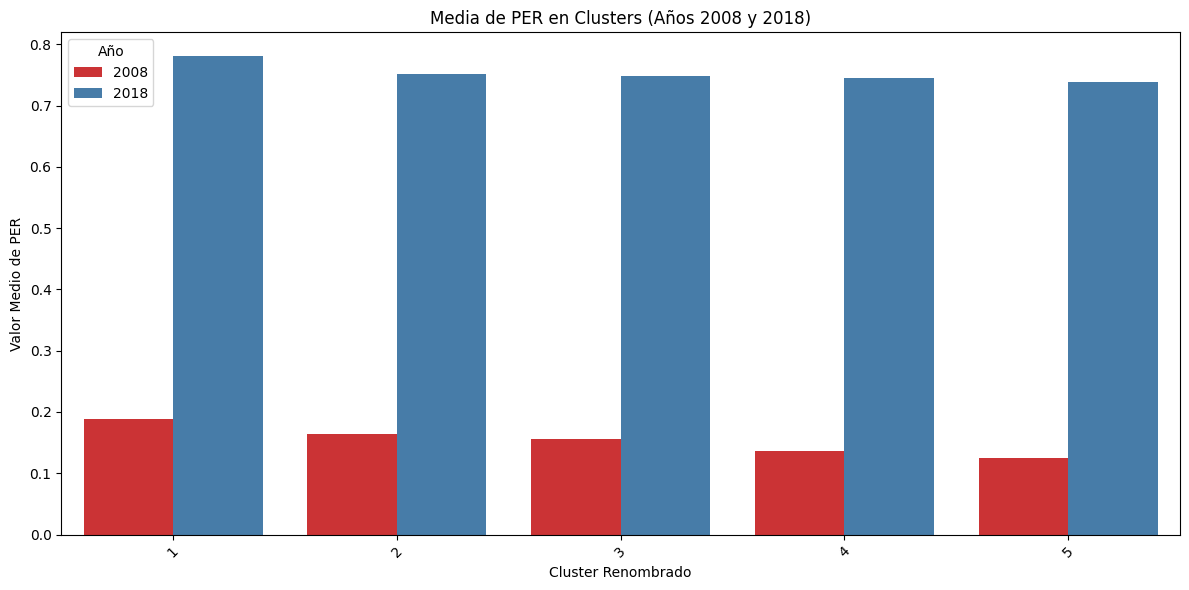

<ipython-input-113-37368cb6c4ac>:16: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




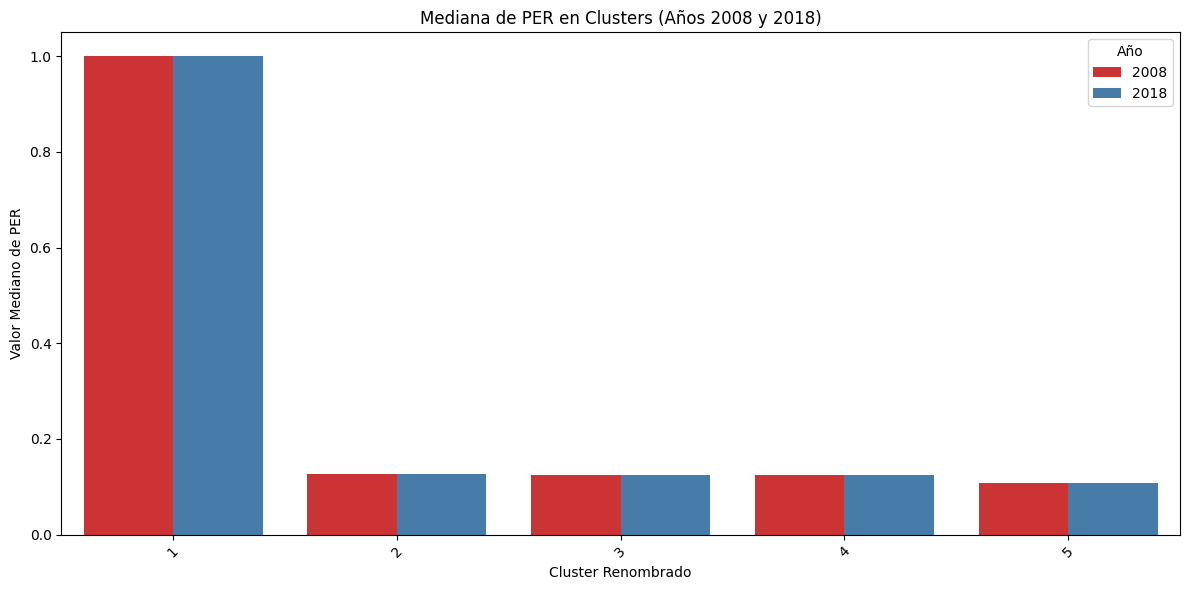

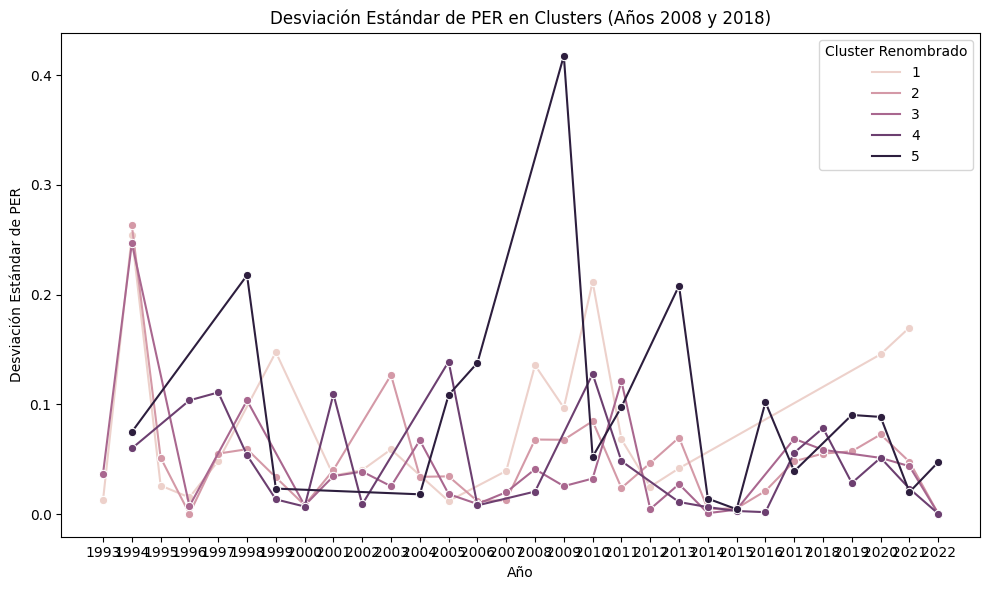

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización de las diferencias entre clusters en 2008 y 2018 (usando gráficos de barras)
plt.figure(figsize=(12, 6))
sns.barplot(data=media_cluster_f, x='cluster_renombrado', y='PER', hue='Year', ci=None)
plt.title('Media de PER en Clusters (Años 2008 y 2018)')
plt.xlabel('Cluster Renombrado')
plt.ylabel('Valor Medio de PER')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=median_cluster_f, x='cluster_renombrado', y='PER', hue='Year', ci=None)
plt.title('Mediana de PER en Clusters (Años 2008 y 2018)')
plt.xlabel('Cluster Renombrado')
plt.ylabel('Valor Mediano de PER')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()
plt.show()

# Validación y análisis adicional
# Ejemplo de análisis estadístico simple
# Calcular la desviación estándar de PER en cada cluster y año
std_deviation_per = resultado_cluster.groupby(['cluster_renombrado', 'Year'])['PER'].std().reset_index()

# Visualización de la desviación estándar de PER
plt.figure(figsize=(10, 6))
sns.lineplot(data=std_deviation_per, x='Year', y='PER', hue='cluster_renombrado', marker='o')
plt.title('Desviación Estándar de PER en Clusters (Años 2008 y 2018)')
plt.xlabel('Año')
plt.ylabel('Desviación Estándar de PER')
plt.legend(title='Cluster Renombrado')
plt.tight_layout()
plt.show()


<ipython-input-114-290f8e917a5d>:6: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




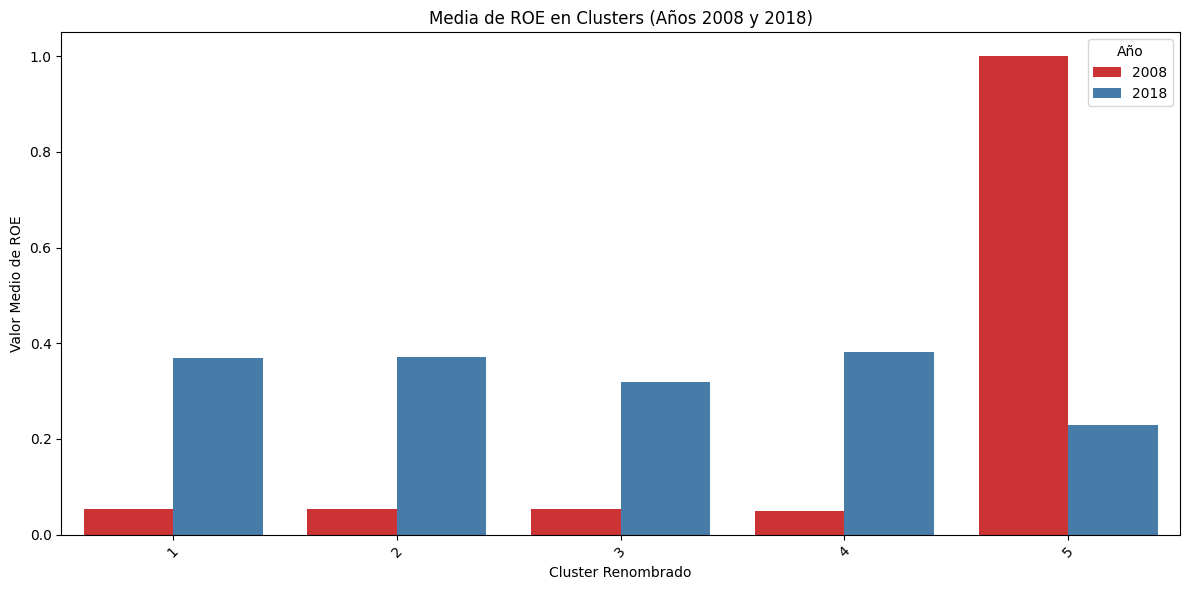

<ipython-input-114-290f8e917a5d>:16: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




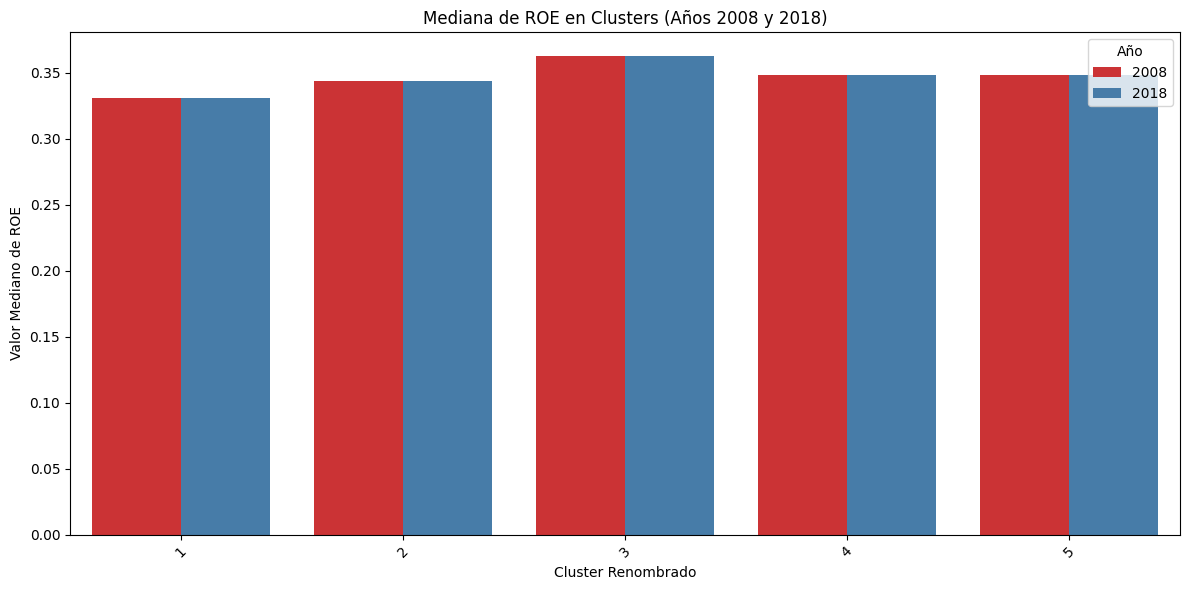

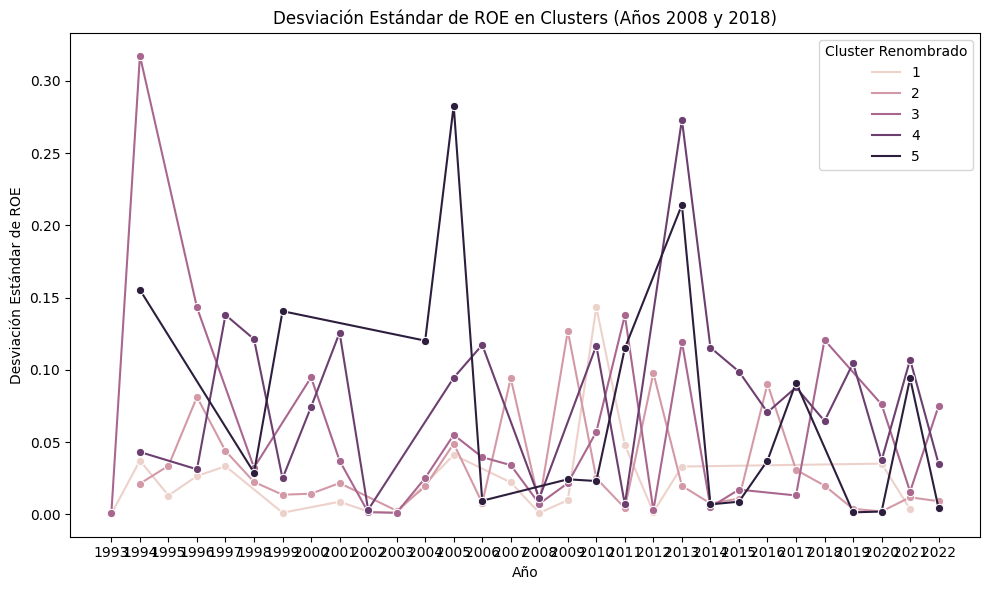

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualización de las diferencias entre clusters en 2008 y 2018 (usando gráficos de barras)
plt.figure(figsize=(12, 6))
sns.barplot(data=media_cluster_f, x='cluster_renombrado', y='ROE', hue='Year', ci=None)
plt.title('Media de ROE en Clusters (Años 2008 y 2018)')
plt.xlabel('Cluster Renombrado')
plt.ylabel('Valor Medio de ROE')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=median_cluster_f, x='cluster_renombrado', y='ROE', hue='Year', ci=None)
plt.title('Mediana de ROE en Clusters (Años 2008 y 2018)')
plt.xlabel('Cluster Renombrado')
plt.ylabel('Valor Mediano de ROE')
plt.xticks(rotation=45)
plt.legend(title='Año')
plt.tight_layout()
plt.show()

# Validación y análisis adicional
# Ejemplo de análisis estadístico simple
# Calcular la desviación estándar de ROE en cada cluster y año
std_deviation_roe = resultado_cluster.groupby(['cluster_renombrado', 'Year'])['ROE'].std().reset_index()

# Visualización de la desviación estándar de ROE
plt.figure(figsize=(10, 6))
sns.lineplot(data=std_deviation_roe, x='Year', y='ROE', hue='cluster_renombrado', marker='o')
plt.title('Desviación Estándar de ROE en Clusters (Años 2008 y 2018)')
plt.xlabel('Año')
plt.ylabel('Desviación Estándar de ROE')
plt.legend(title='Cluster Renombrado')
plt.tight_layout()
plt.show()


## Tracking record del movimiento de las variables

In [115]:
# Queremos ver como cuales fueron las acciones que más cambiaron a lo largo del tiempo
resul_clus_copy = resultado_cluster.copy()
resul_clus_copy = resul_clus_copy.reset_index()
acciones = resul_clus_copy.groupby("Accion")["cluster_renombrado"].apply(lambda x: x.diff().ne(0).sum()).reset_index(name="num_cambios")
accinoes_ordenadas = acciones.sort_values(by="num_cambios", ascending=False)
top_10_acciones = accinoes_ordenadas.head(20)

results = []

for accion in top_10_acciones["Accion"]:
    accion_data = resul_clus_copy[resul_clus_copy["Accion"] == accion]
    cambios = accion_data["cluster_renombrado"].diff().ne(0).sum()
    primer_cluster = accion_data.iloc[0]["cluster_renombrado"]
    ultimo_cluster = accion_data.iloc[-1]["cluster_renombrado"]
    results.append({
        "Accion": accion,
        "Cambios": cambios,
        "Cluster_inicial": primer_cluster,
        "Cluster_final": ultimo_cluster
    })

results_df = pd.DataFrame(results)

results_df

,Accion,Cambios,Cluster_inicial,Cluster_final
0,MTCH,26,4,3
1,STZ,24,4,3
2,BDX,23,1,4
3,BA,23,3,5
4,COO,22,4,4
5,CAT,22,4,4
6,SYK,22,4,4
7,HPQ,22,3,4
8,LMT,22,3,3
9,DHR,22,4,4


Desviacion estandar como medida de tracking entre clusters

Acciones que más se movieron:
Accion: FOXA, Desviación Estándar: 1.53
Accion: FOX, Desviación Estándar: 1.53
Accion: AMT, Desviación Estándar: 1.49
Accion: SBAC, Desviación Estándar: 1.48
Accion: TER, Desviación Estándar: 1.47
Accion: NWS, Desviación Estándar: 1.43
Accion: NWSA, Desviación Estándar: 1.43
Accion: ADP, Desviación Estándar: 1.42
Accion: CTSH, Desviación Estándar: 1.42
Accion: OGN, Desviación Estándar: 1.41


<ipython-input-116-84ce8d7e2035>:12: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



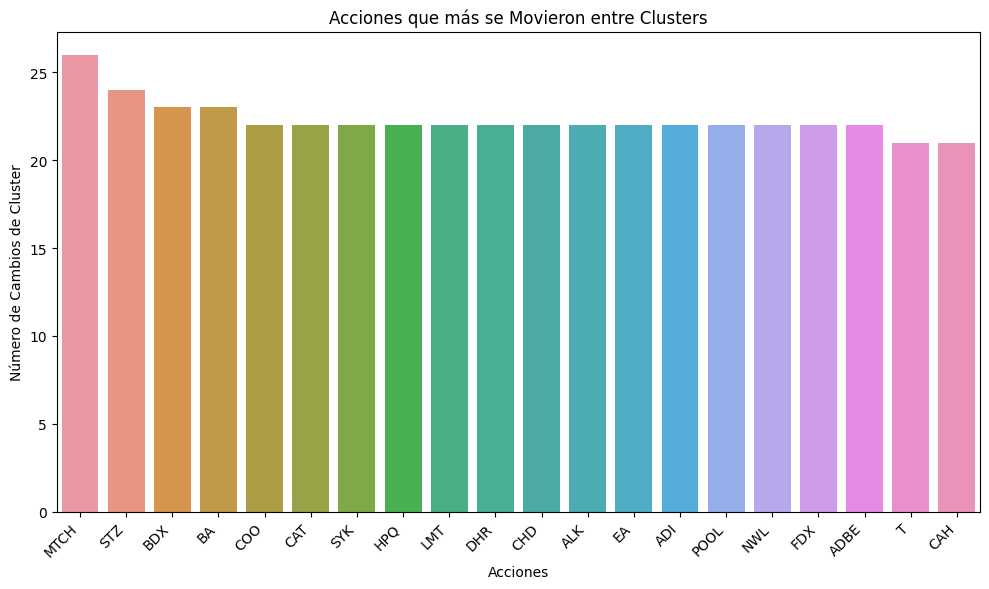

In [116]:
# Calcular la desviación estándar para cada acción
std_deviation = resultado_cluster.groupby('Accion')['cluster_renombrado'].std()

# Ordenar las acciones según la desviación estándar en orden descendente
actions_with_std = std_deviation.sort_values(ascending=False)

# Obtener las acciones que más se movieron
top_moving_actions = actions_with_std.head(10)

# Mostrar las acciones que más se movieron
print("Acciones que más se movieron:")
for action, std in top_moving_actions.iteritems():
    print(f"Accion: {action}, Desviación Estándar: {std:.2f}")

# Crear un gráfico de barras para mostrar la cantidad de cambios de cluster por acción
plt.figure(figsize=(10, 6))
sns.barplot(x='Accion', y='num_cambios', data=top_10_acciones)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Acciones')
plt.ylabel('Número de Cambios de Cluster')
plt.title('Acciones que más se Movieron entre Clusters')
plt.tight_layout()
plt.show()


Acciones que menos cambiaron

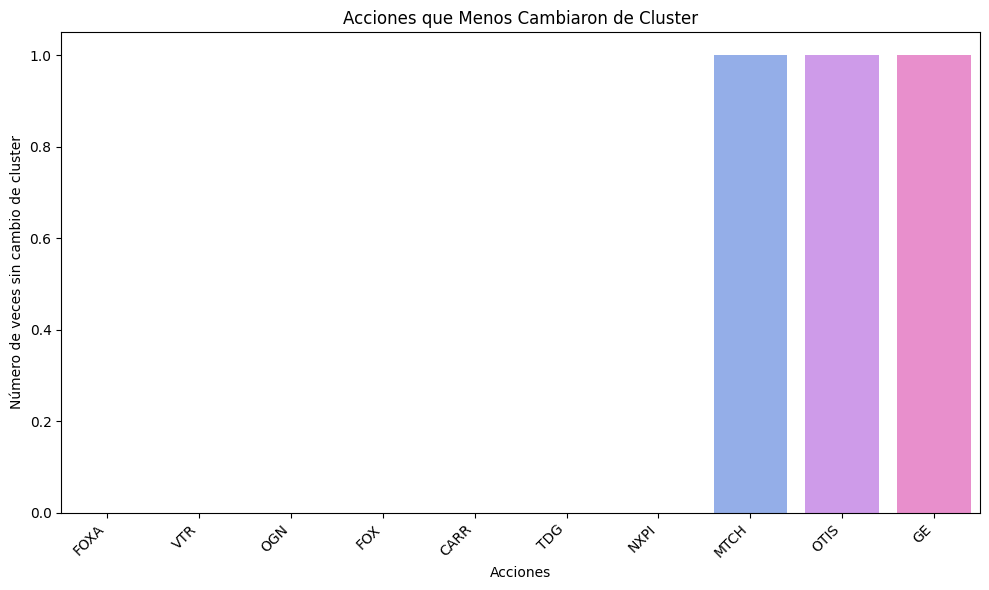

,Accion,num_cambios
77,FOXA,0
203,VTR,0
146,OGN,0
76,FOX,0
29,CARR,0
183,TDG,0
144,NXPI,0
134,MTCH,1
148,OTIS,1
80,GE,1


In [117]:
# Queremos ver las acciones que menos cambiaron a lo largo del tiempo
acciones_menos_cambio = resul_clus_copy.groupby("Accion")["cluster_renombrado"].apply(lambda x: x.diff().eq(0).sum()).reset_index(name="num_cambios")

# Ordenamos de manera ascendente para obtener las acciones que menos cambiaron
acciones_menos_cambio = acciones_menos_cambio.sort_values(by="num_cambios")

# Mostramos las 10 acciones que menos cambiaron
top_10_menos_cambio = acciones_menos_cambio.head(10)

# Graficamos las acciones que menos cambiaron
plt.figure(figsize=(10, 6))
sns.barplot(x='Accion', y='num_cambios', data=top_10_menos_cambio)
plt.xticks(rotation=45, ha="right")
plt.xlabel('Acciones')
plt.ylabel('Número de veces sin cambio de cluster')
plt.title('Acciones que Menos Cambiaron de Cluster')
plt.tight_layout()
plt.show()

top_10_menos_cambio


In [118]:
# Calculamos la desviación estándar para cada acción
std_deviation = resultado_cluster.groupby('Accion')['cluster_renombrado'].std()

# Calculamos el promedio de las desviaciones estándar
average_std_deviation = std_deviation.mean()

print(f"Promedio de desviación estándar de cambios de cluster: {average_std_deviation:.2f}")

Promedio de desviación estándar de cambios de cluster: 1.09


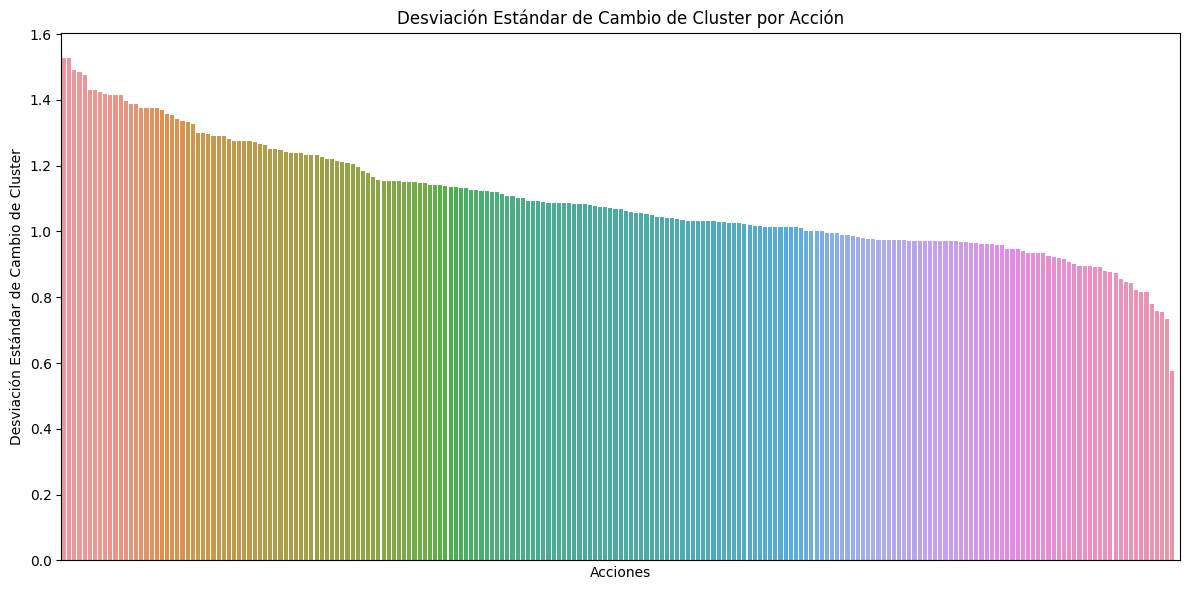

In [119]:
# Calculamos la desviación estándar para cada acción
std_deviation = resultado_cluster.groupby('Accion')['cluster_renombrado'].std()

# Ordenamos las acciones según la desviación estándar en orden descendente
actions_with_std = std_deviation.sort_values(ascending=False)

# Creamos un gráfico de barras para mostrar la desviación estándar de los movimientos de cluster por acción
plt.figure(figsize=(12, 6))
sns.barplot(x=actions_with_std.index, y=actions_with_std.values)
plt.xlabel('Acciones')
plt.ylabel('Desviación Estándar de Cambio de Cluster')
plt.title('Desviación Estándar de Cambio de Cluster por Acción')
plt.xticks([])  # Esto elimina los nombres de las acciones en el eje x
plt.tight_layout()
plt.show()


## Acciones mas cercanas a cada centroide por año



In [120]:
cluster_centroids = resultado_cluster.groupby(['Year', 'cluster_renombrado']).mean().reset_index()

# Creamos un DataFrame para almacenar las acciones más cercanas a los centroides
acciones_cercanas_df = pd.DataFrame(columns=['Year', 'Cluster', 'Accion'])

# Iteramos a través de cada año y clúster
for year in cluster_centroids['Year'].unique():
    year_data = resultado_cluster[resultado_cluster['Year'] == year]

    for cluster in cluster_centroids[cluster_centroids['Year'] == year]['cluster_renombrado']:
        cluster_center = cluster_centroids[(cluster_centroids['Year'] == year) & (cluster_centroids['cluster_renombrado'] == cluster)].iloc[0, 2:-1]

        # Calculamos la distancia de cada acción al centroide del clúster
        distances = []
        for index, row in year_data[year_data['cluster_renombrado'] == cluster].iterrows():
            action_data = row[2:-1]
            distances.append((year, cluster, row.name))

        if distances:
            # Encontramos la acción más cercana
            closest_action = min(distances)
            acciones_cercanas_df = pd.concat([acciones_cercanas_df, pd.DataFrame([closest_action], columns=['Year', 'Cluster', 'Accion'])], ignore_index=True)


acciones_cercanas_df

<ipython-input-120-b988e74ad8cd>:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Year,Cluster,Accion
0,1993,1,BDX
1,1993,2,MSFT
2,1993,3,BA
3,1993,4,COO
4,1993,5,KMB
...,...,...,...
145,2022,1,AMT
146,2022,2,CCI
147,2022,3,AAL
148,2022,4,A


# Etapa 3: Construcción de Índice

En esta etapa, creamos un índice comparativo utilizando los datos de los clusters y los precios de las acciones. Luego, visualizamos la comparación de este índice con el índice S&P 500.

## Importamos los datos del S&P 500 para la construcción del Indice



In [121]:
# Traemos los datos historicos diarios del sp 500

df_sp = pd.read_csv("https://media.githubusercontent.com/media/Santigago97/Master/main/sp500.csv")
df_sp["Date"] = pd.to_datetime(df_sp["Date"], errors = "raise", infer_datetime_format=True)
df_sp["Rentabilidad"] = df_sp["SP500"].pct_change()
df_sp.fillna(0,inplace = True)
df_sp["indice"] = (1 + df_sp["Rentabilidad"]).cumprod()
df_sp.head()


,Date,SP500,Rentabilidad,indice
0,1999-11-18,1424.939941,0.000000,1.000000
1,1999-11-19,1422.000000,-0.002063,0.997937
2,1999-11-22,1420.939941,-0.000745,0.997193
3,1999-11-23,1404.640015,-0.011471,0.985754
4,1999-11-24,1417.079956,0.008856,0.994484


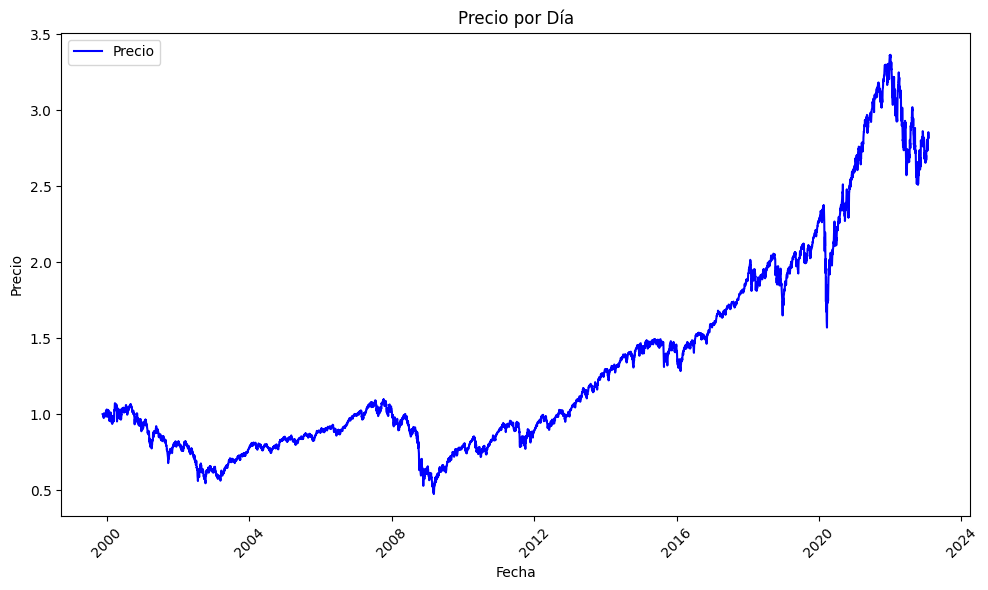

In [122]:
#Ploteamos el indice para ver como se comporta graficamente el indice previamente creado

# Creamos un gráfico de líneas
plt.figure(figsize=(10, 6))  # Tamaño de la figura

# Ploteamos la rentabilidad por día
plt.plot(df_sp["Date"], df_sp["indice"], linestyle='-', color='b', label='Precio')

# Configuramos el eje x
plt.xticks(rotation=45)
plt.xlabel('Fecha')
plt.ylabel('Precio')

# Agregamos título y leyenda
plt.title('Precio por Día')
plt.legend()

# Mostramos el gráfico
plt.tight_layout()
plt.show()


## Importamos los precios diarios de las acciones para la construcción del Indice

---

In [123]:
# Importamos los datos de precios diarios de cada acción

df_precios = pd.read_csv("https://media.githubusercontent.com/media/Santigago97/Master/main/precios_acciones.csv")
df_precios["Date"] = pd.to_datetime(df_precios["Date"], errors = "raise", infer_datetime_format=True)
df_precios.set_index("Date", inplace = True)
df_precios = df_precios.pct_change()
df_precios.fillna(0, inplace = True)
df_precios

,A,AAL,AAP,AAPL,ABBV,ABC,ACN,ADBE,ADI,ADM,...,WMT,WRK,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1999-11-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-11-19,-0.082386,0.000000,0.000000,0.031381,0.000000,-0.009050,0.000000,-0.006568,-0.016719,0.000000,...,-0.021053,0.000000,-0.025793,0.000000,-0.015198,-0.016962,0.000000,-0.014493,0.000000,0.000000
1999-11-22,0.089783,0.000000,0.000000,-0.019608,0.000000,-0.031964,0.000000,0.005785,-0.052072,-0.027273,...,-0.023656,0.000000,-0.013238,0.000000,0.000000,-0.001765,0.000000,-0.016177,0.000000,0.000000
1999-11-23,-0.090909,0.000000,0.000000,0.024137,0.000000,-0.070755,0.000000,-0.017255,0.004485,-0.037383,...,-0.014318,0.000000,0.000000,0.000000,-0.009259,-0.019446,0.000000,-0.016442,0.000000,0.000000
1999-11-24,0.026562,0.000000,0.000000,0.020202,0.000000,0.000000,0.000000,0.004180,0.015625,0.004855,...,0.035754,0.000000,-0.001806,0.000000,0.003115,0.014423,0.000000,-0.024316,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-24,-0.021187,-0.009276,-0.009083,0.010063,-0.005789,-0.001793,-0.016002,-0.010028,-0.004715,0.016835,...,0.002664,-0.012977,-0.004944,-0.011566,0.004852,0.009312,0.021199,0.014526,-0.003653,-0.005157
2023-01-25,0.000450,0.014981,0.012494,-0.004701,0.000677,0.012575,-0.006221,-0.008718,-0.002428,-0.002332,...,-0.004755,0.004656,0.017081,-0.005447,0.003219,-0.005272,-0.009945,0.005369,-0.004622,-0.002291
2023-01-26,0.003017,0.021525,-0.009993,0.014803,-0.002639,0.008871,0.004027,0.021359,0.013595,-0.007830,...,-0.000913,0.037350,0.027481,0.043209,0.003501,0.040191,-0.011800,-0.001238,0.004804,0.016495


In [124]:
df_precios = pd.melt(df_precios,value_vars=df_precios.columns, var_name = "Accion", value_name = "Rentabilidad", ignore_index= False)
df_precios.reset_index(inplace = True)
df_precios.replace([np.inf, -np.inf,-1], 0, inplace = True)
df_precios["Llave"] = df_precios["Date"].dt.year.astype("str") + df_precios["Accion"].str.upper()

df_precios

,Date,Accion,Rentabilidad,Llave
0,1999-11-18,A,0.000000,1999A
1,1999-11-19,A,-0.082386,1999A
2,1999-11-22,A,0.089783,1999A
3,1999-11-23,A,-0.090909,1999A
4,1999-11-24,A,0.026562,1999A
...,...,...,...,...
1826663,2023-01-24,ZTS,-0.005157,2023ZTS
1826664,2023-01-25,ZTS,-0.002291,2023ZTS
1826665,2023-01-26,ZTS,0.016495,2023ZTS
1826666,2023-01-27,ZTS,-0.018188,2023ZTS


In [125]:
# Juntamos el los datasets de clustering con el de precios para empezar a construir el indice
df_precios_merge = df_precios.merge(resultado_cluster[["Llave","cluster_renombrado"]], on = "Llave", how="left")

# Creamos la varibale rentabilidad y el indice por acción

df_precios_merge.dropna(subset=["cluster_renombrado"], inplace=True)
df_precios_merge["cluster_renombrado"] = df_precios_merge["cluster_renombrado"].astype("int64")
df_precios_merge.sort_values(["Accion","Date"], ascending=True, inplace=True)

df_precios_merge


,Date,Accion,Rentabilidad,Llave,cluster_renombrado
0,1999-11-18,A,0.000000,1999A,2
1,1999-11-19,A,-0.082386,1999A,2
2,1999-11-22,A,0.089783,1999A,2
3,1999-11-23,A,-0.090909,1999A,2
4,1999-11-24,A,0.026562,1999A,2
...,...,...,...,...,...
1826644,2022-12-23,ZTS,0.005033,2022ZTS,3
1826645,2022-12-27,ZTS,-0.003156,2022ZTS,3
1826646,2022-12-28,ZTS,-0.010117,2022ZTS,3
1826647,2022-12-29,ZTS,0.030035,2022ZTS,3


## Calculamos la rentabilidad equiponderada por día y cluster

In [126]:
# Calculamos la rentabilidad equiponderada por día y cluster
df_precios_merge['Rent_equi_X_Accion'] = df_precios_merge['Rentabilidad'] * (1 / df_precios_merge.groupby(["Date", "cluster_renombrado"])['Accion'].transform('count'))

# Creamos un DataFrame auxiliar para calcular las sumas de rentabilidades equiponderadas por día y cluster
df_sumas_equiponderadas = df_precios_merge.groupby(['Date', 'cluster_renombrado'])['Rent_equi_X_Accion'].sum().reset_index()

# Renombramos la columna de sumas
df_sumas_equiponderadas.rename(columns={'Rent_equi_X_Accion': 'Rentabilidad_Equiponderada'}, inplace=True)

# Combinamos las sumas al DataFrame original usando 'Date' y 'cluster_renombrado'
df_precios_merge = df_precios_merge.merge(df_sumas_equiponderadas, on=['Date', 'cluster_renombrado'], how='left')

df_precios_merge.rename(columns={"Suma_Rentabilidad_Equiponderada_x":"Rentabilidad_Equiponderada"})

# Imprimimos el DataFrame con las nuevas columnas para la fecha específica
df_precios_merge.tail()

,Date,Accion,Rentabilidad,Llave,cluster_renombrado,Rent_equi_X_Accion,Rentabilidad_Equiponderada
1108079,2022-12-23,ZTS,0.005033,2022ZTS,3,0.000057,0.006490
1108080,2022-12-27,ZTS,-0.003156,2022ZTS,3,-0.000036,0.002889
1108081,2022-12-28,ZTS,-0.010117,2022ZTS,3,-0.000115,-0.013166
1108082,2022-12-29,ZTS,0.030035,2022ZTS,3,0.000341,0.014760
1108083,2022-12-30,ZTS,-0.010800,2022ZTS,3,-0.000123,-0.007300


In [127]:
# Creamos los indices
df_merge_unico = df_precios_merge[['Date', 'cluster_renombrado', 'Rentabilidad_Equiponderada']].drop_duplicates()
df_merge_unico.sort_values(by=["cluster_renombrado", "Date"], inplace=True)
df_merge_unico["indice"] = df_merge_unico.groupby('cluster_renombrado', group_keys=False)['Rentabilidad_Equiponderada'].apply(lambda x: (1 + x).cumprod()).round(4)
df_merge_unico

,Date,cluster_renombrado,Rentabilidad_Equiponderada,indice
530595,1999-11-18,1,0.000000,1.0000
530596,1999-11-19,1,0.001798,1.0018
530597,1999-11-22,1,0.031892,1.0337
530598,1999-11-23,1,-0.008762,1.0247
530599,1999-11-24,1,0.017073,1.0422
...,...,...,...,...
130596,2022-12-23,5,0.000510,37.0430
130597,2022-12-27,5,-0.009535,36.6898
130598,2022-12-28,5,-0.008736,36.3693
130599,2022-12-29,5,0.005575,36.5720


## Creamos un dataframe con el indice de los clusters y el indice del S&P 500

---

In [128]:
# Construimos el dataset final del S&P 500 para combinarlo luego con el dataset final

df_sp_final = pd.DataFrame()
df_sp_final["Date"] = df_sp["Date"]
df_sp_final["cluster_renombrado"]= "SP500"
df_sp_final["indice"]= df_sp["indice"]

df_sp_final.head()

,Date,cluster_renombrado,indice
0,1999-11-18,SP500,1.000000
1,1999-11-19,SP500,0.997937
2,1999-11-22,SP500,0.997193
3,1999-11-23,SP500,0.985754
4,1999-11-24,SP500,0.994484


In [129]:
#Creamos el data set final que vamos a plotear para comparar los indices previamente creados

df_final = df_merge_unico[["Date","cluster_renombrado","indice"]]
df_final = pd.concat([df_final,df_sp_final])

df_final

,Date,cluster_renombrado,indice
530595,1999-11-18,1,1.000000
530596,1999-11-19,1,1.001800
530597,1999-11-22,1,1.033700
530598,1999-11-23,1,1.024700
530599,1999-11-24,1,1.042200
...,...,...,...
5831,2023-01-24,SP500,2.819031
5832,2023-01-25,SP500,2.818519
5833,2023-01-26,SP500,2.849545
5834,2023-01-27,SP500,2.856654


## - Graficamos los indices para comparar y ver sus rentabilidades

---

In [130]:
# Crear un menú desplegable con las opciones únicas de cluster_renombrado
cluster_options = df_final['cluster_renombrado'].unique()
cluster_dropdown = widgets.SelectMultiple(
    options=cluster_options,
    description='Clusters',
    disabled=False
)

# Función para actualizar el gráfico según las opciones seleccionadas
def update_plot(selected_clusters):
    plt.figure(figsize=(10, 6))
    for cluster in selected_clusters:
        cluster_data = df_final[df_final['cluster_renombrado'] == cluster]
        plt.plot(cluster_data['Date'], cluster_data['indice'], label=cluster)
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Comparación de Clusters a lo largo del tiempo')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Mostrar el menú desplegable y el gráfico interactivo
widgets.interactive(update_plot, selected_clusters=cluster_dropdown)

interactive(children=(SelectMultiple(description='Clusters', options=(1, 2, 3, 4, 5, 'SP500'), value=()), Outp…

In [131]:
# Comparación de indices de los clusters

df_final["años"] = (df_final['Date'].iloc[-1] - df_final['Date'].iloc[0]).days / 365
cagr_data = df_final.groupby('cluster_renombrado').apply(lambda x: ((x['indice'].iloc[-1]) ** (1 / x['años'].iloc[0])) - 1)*100
df_final['retorno'] = df_final.groupby('cluster_renombrado')['indice'].pct_change()
rentabilidad_promedio = (df_final.groupby('cluster_renombrado')['retorno'].mean())*100
volatilidad = (df_final.groupby('cluster_renombrado')['retorno'].std())*100
desviacion_estandar = df_final.groupby('cluster_renombrado')['indice'].std()
maximo = df_final.groupby('cluster_renombrado')['indice'].max()
minimo = df_final.groupby('cluster_renombrado')['indice'].min()

resultados = pd.DataFrame({
    'Rentabilidad Promedio': rentabilidad_promedio,
    'Volatilidad': volatilidad,
    'Desviación Estándar': desviacion_estandar,
    'Máximo': maximo,
    'Mínimo': minimo,
    'CAGR': cagr_data,
})

def calculate_drawdown(series):
    cum_return = (1 + series).cumprod()
    max_drawdown = (cum_return / cum_return.cummax() - 1).min()
    return max_drawdown

drawdown_maximo = df_final.groupby('cluster_renombrado')['retorno'].apply(calculate_drawdown) * 100
resultados['Drawdown Máximo'] = drawdown_maximo

resultados


,Rentabilidad Promedio,Volatilidad,Desviación Estándar,Máximo,Mínimo,CAGR,Drawdown Máximo
cluster_renombrado,,,,,,,
1,0.083678,1.699114,19.816801,77.430300,0.975800,18.960400,-58.585226
2,0.066216,1.320087,8.655302,35.156400,1.000000,15.490881,-46.178970
3,0.061939,1.303109,6.535068,24.369700,0.790600,14.324682,-47.290103
4,0.101026,1.989301,32.324328,128.654400,0.923300,22.641564,-75.838083
5,0.090126,2.385947,10.016659,38.112800,0.726100,16.761951,-80.081679
SP500,0.025568,1.248005,0.680253,3.366149,0.474778,4.566107,-56.775388


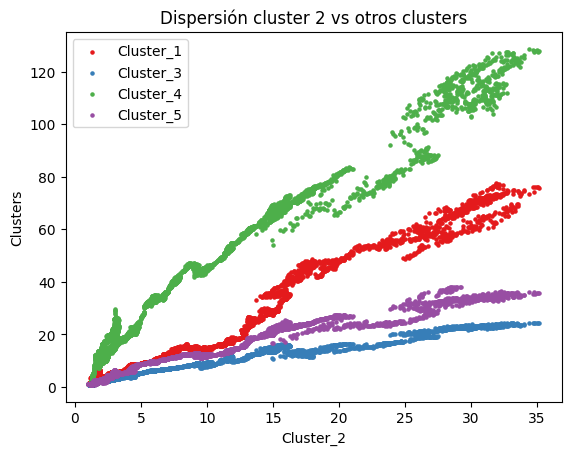

In [132]:
# Filtramos los datos para seleccionar los puntos en el cluster 2 y el resto de clusters

cluster_2_data = df_final[df_final["cluster_renombrado"] == 2]
cluster_1_data = df_final[df_final["cluster_renombrado"] == 1]
cluster_3_data = df_final[df_final["cluster_renombrado"] == 3]
cluster_4_data = df_final[df_final["cluster_renombrado"] == 4]
cluster_5_data = df_final[df_final["cluster_renombrado"] == 5]
cluster_sp_data = df_final[df_final["cluster_renombrado"] == "SP500"]


#Creamos el gráfico de dispersión

plt.title("Dispersión cluster 2 vs otros clusters")
plt.xlabel("Cluster_2")
plt.ylabel("Clusters")
plt.scatter(cluster_2_data["indice"], cluster_1_data["indice"], label = "Cluster_1",s = 5)
plt.scatter(cluster_2_data["indice"], cluster_3_data["indice"], label = "Cluster_3",s = 5)
plt.scatter(cluster_2_data["indice"], cluster_4_data["indice"], label = "Cluster_4",s = 5)
plt.scatter(cluster_2_data["indice"], cluster_5_data["indice"], label = "Cluster_5",s = 5)
plt.legend()

plt.show()

In [133]:
#Creamos los arrays por cluster para determinar la covarianza de todos los clusters con el cluster 2

cluster_2_array = np.array(cluster_2_data["indice"])
cluster_1_array = np.array(cluster_1_data["indice"])
cluster_3_array = np.array(cluster_3_data["indice"])
cluster_4_array = np.array(cluster_4_data["indice"])
cluster_5_array = np.array(cluster_5_data["indice"])
cluster_sp_array = np.array(cluster_sp_data["indice"])

covarianza_1 = np.cov(cluster_2_array,cluster_1_array)[0][1]
covarianza_3 = np.cov(cluster_2_array,cluster_3_array)[0][1]
covarianza_4 = np.cov(cluster_2_array,cluster_4_array)[0][1]
covarianza_5 = np.cov(cluster_2_array,cluster_5_array)[0][1]


print ("La covarianza para el cluster 2 y 1 es de: ", round(covarianza_1, 4))
print ("La covarianza para el cluster 2 y 3 es de: ", round(covarianza_3,4))
print ("La covarianza para el cluster 2 y 4 es de: ", round(covarianza_4,4))
print ("La covarianza para el cluster 2 y 5 es de: ", round(covarianza_5,4))


La covarianza para el cluster 2 y 1 es de:  169.3539
La covarianza para el cluster 2 y 3 es de:  55.9526
La covarianza para el cluster 2 y 4 es de:  274.8239
La covarianza para el cluster 2 y 5 es de:  85.3692


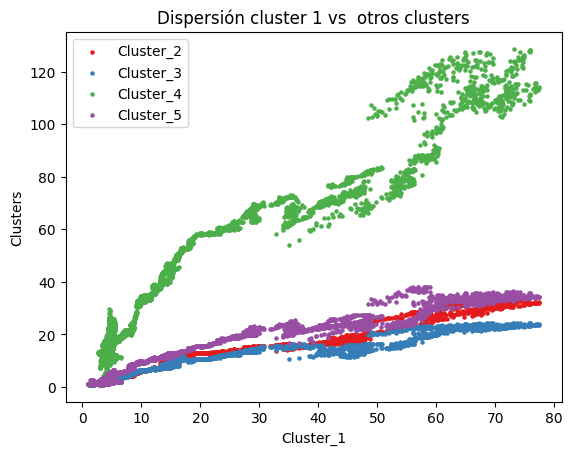

In [134]:
#Creamos el gráfico de dispersión

plt.title("Dispersión cluster 1 vs  otros clusters")
plt.xlabel("Cluster_1")
plt.ylabel("Clusters")
plt.scatter(cluster_1_data["indice"], cluster_2_data["indice"], label = "Cluster_2",s = 5)
plt.scatter(cluster_1_data["indice"], cluster_3_data["indice"], label = "Cluster_3",s = 5)
plt.scatter(cluster_1_data["indice"], cluster_4_data["indice"], label = "Cluster_4",s = 5)
plt.scatter(cluster_1_data["indice"], cluster_5_data["indice"], label = "Cluster_5",s = 5)
plt.legend()

plt.show()

In [135]:
covarianza_3 = np.cov(cluster_1_array,cluster_3_array)[0][1]
covarianza_4 = np.cov(cluster_1_array,cluster_4_array)[0][1]
covarianza_5 = np.cov(cluster_1_array,cluster_5_array)[0][1]


print ("La covarianza para el cluster 1 y 3 es de: ", round(covarianza_3,4))
print ("La covarianza para el cluster 1 y 4 es de: ", round(covarianza_4,4))
print ("La covarianza para el cluster 1 y 5 es de: ", round(covarianza_5,4))


La covarianza para el cluster 1 y 3 es de:  125.2327
La covarianza para el cluster 1 y 4 es de:  613.4098
La covarianza para el cluster 1 y 5 es de:  192.4008


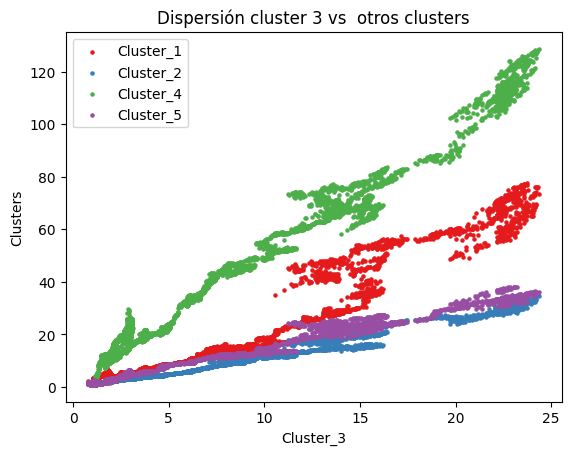

In [136]:
#Creamos el gráfico de dispersión

plt.title("Dispersión cluster 3 vs  otros clusters")
plt.xlabel("Cluster_3")
plt.ylabel("Clusters")
plt.scatter(cluster_3_data["indice"], cluster_1_data["indice"], label = "Cluster_1",s = 5)
plt.scatter(cluster_3_data["indice"], cluster_2_data["indice"], label = "Cluster_2",s = 5)
plt.scatter(cluster_3_data["indice"], cluster_4_data["indice"], label = "Cluster_4",s = 5)
plt.scatter(cluster_3_data["indice"], cluster_5_data["indice"], label = "Cluster_5",s = 5)
plt.legend()

plt.show()

In [137]:

covarianza_4 = np.cov(cluster_3_array,cluster_4_array)[0][1]
covarianza_5 = np.cov(cluster_3_array,cluster_5_array)[0][1]

print ("La covarianza para el cluster 3 y 4 es de: ", round(covarianza_4,4))
print ("La covarianza para el cluster 3 y 5 es de: ", round(covarianza_5,4))

La covarianza para el cluster 3 y 4 es de:  209.1082
La covarianza para el cluster 3 y 5 es de:  64.9889


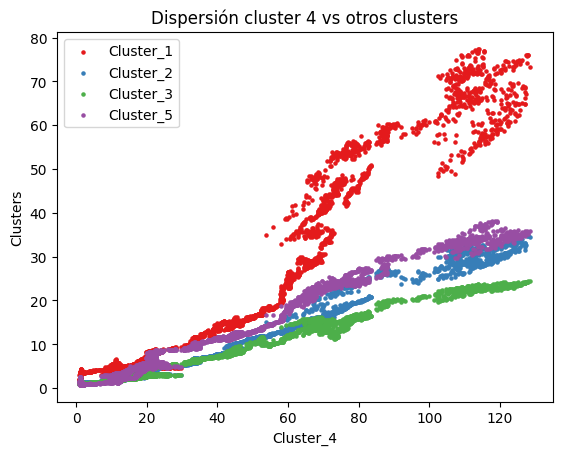

In [138]:
#Creamos el gráfico de dispersión

plt.title("Dispersión cluster 4 vs otros clusters")
plt.xlabel("Cluster_4")
plt.ylabel("Clusters")
plt.scatter(cluster_4_data["indice"], cluster_1_data["indice"], label = "Cluster_1",s = 5)
plt.scatter(cluster_4_data["indice"], cluster_2_data["indice"], label = "Cluster_2",s = 5)
plt.scatter(cluster_4_data["indice"], cluster_3_data["indice"], label = "Cluster_3",s = 5)
plt.scatter(cluster_4_data["indice"], cluster_5_data["indice"], label = "Cluster_5",s = 5)
plt.legend()

plt.show()

In [139]:
covarianza_4 = np.cov(cluster_5_array,cluster_4_array)[0][1]


print ("La covarianza para el cluster 5 y 4 es de: ", round(covarianza_4,4))

La covarianza para el cluster 5 y 4 es de:  320.5408


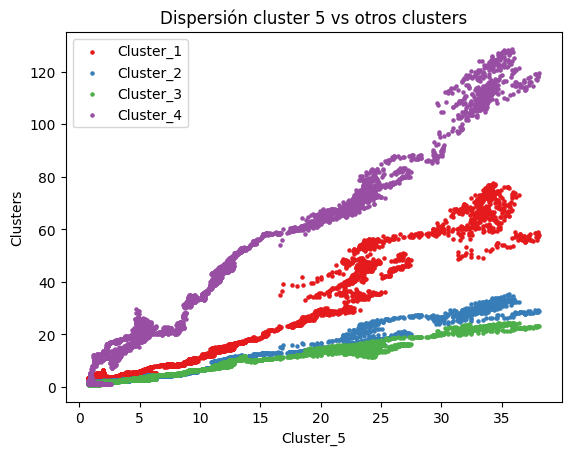

In [140]:
#Creamos el gráfico de dispersión

plt.title("Dispersión cluster 5 vs otros clusters")
plt.xlabel("Cluster_5")
plt.ylabel("Clusters")
plt.scatter(cluster_5_data["indice"], cluster_1_data["indice"], label = "Cluster_1",s = 5)
plt.scatter(cluster_5_data["indice"], cluster_2_data["indice"], label = "Cluster_2",s = 5)
plt.scatter(cluster_5_data["indice"], cluster_3_data["indice"], label = "Cluster_3",s = 5)
plt.scatter(cluster_5_data["indice"], cluster_4_data["indice"], label = "Cluster_4",s = 5)
plt.legend()

plt.show()